# Baseline model based on anatomy features

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [3]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

In [12]:
import re 

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin



class FeatureExtractor(BaseEstimator, TransformerMixin):

    def fit(self, x_df, y):
        return self

    def transform(self, x_df):
        new_x_df = get_transformed_features(x_df)
        return new_x_df[top_corr_selected_columns]


def get_transformed_features(x_df):
    
    print("-- get_transformed_features --- ")
    accepted_anatomy = x_df['anatomy_select'].isin([1, 2])
    new_x_df = x_df[accepted_anatomy].copy()
    print("-> accepted anatomy: {}".format(new_x_df.shape))

    _transform_participant_gender(new_x_df)
    _transform_participant_age(new_x_df)
    
    anatomy_cols = _get_anatomy_columns(new_x_df.columns)
    print("- anatomy_cols : {}".format(len(anatomy_cols)))

    participant_cols = _get_participant_columns(new_x_df.columns)
    print("- participant_cols : {}".format(len(participant_cols)))    
    
    sum_diff_df = _get_sum_diff_anatomy_features(new_x_df)    
    anatomy_sum_diff_cols = sum_diff_df.columns.values.tolist()
    
    print("- anatomy_sum_diff_cols : {}".format(len(anatomy_sum_diff_cols)))    
    new_x_df = pd.concat([new_x_df, diff_df], axis=1)
    print("-> with sum & diff: {}".format(new_x_df.shape))
    
    
#     train_columns1 = anatomy_cols + anatomy_diff_cols + ['participants_age', ]
#     train_columns2 = inverted_cols
#     train_columns = train_columns1 + train_columns2 

#     pairs_df = _get_feature_pairs(new_x_df[train_columns], train_columns1, train_columns2)
#     pairs_columns = pairs_df.columns.values.tolist()
#     print("- pairs_columns : {}".format(len(pairs_columns)))            
#     new_x_df = pd.concat([new_x_df, pairs_df], axis=1)
#     print("-> with pairs: {}".format(new_x_df.shape))

    return new_x_df


def _transform_participant_gender(x_df):
    if x_df['participants_sex'].dtype != np.float64:
        x_df.loc[:, 'participants_sex'] = x_df['participants_sex'].map({'F': -1.0, 'M': +1.0})

        
def _transform_participant_age(x_df):
    if x_df['participants_age'].max() > 1.0:
        x_df.loc[:, 'participants_age'] = x_df['participants_age'] / 100.0
        
        
def _get_anatomy_sum_diff_columns(columns):
    left_cols = sorted([col for col in columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

    left_cols.remove('anatomy_Left-WM-hypointensities')
    left_cols.remove('anatomy_Left-non-WM-hypointensities')

    right_cols = []
    for c in left_cols:
        if "lh" in c:
            c = c.replace("lh", "rh")
        elif "Left" in c:
            c = c.replace("Left", "Right")
        right_cols.append(c)

    anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]
    anatomy_LR_sum_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]    
    
    return anatomy_LR_sum_cols, anatomy_diff_cols
        
        
def _get_anatomy_columns(_):
    
    return ['anatomy_3rd-Ventricle',
             'anatomy_4th-Ventricle',
             'anatomy_Brain-Stem',
             'anatomy_CSF',
             'anatomy_WM-hypointensities',
             'anatomy_Optic-Chiasm',
             'anatomy_CC_Posterior',
             'anatomy_CC_Mid_Posterior',
             'anatomy_CC_Central',
             'anatomy_CC_Mid_Anterior',
             'anatomy_CC_Anterior',
             'anatomy_BrainSegVol',
             'anatomy_BrainSegVolNotVentSurf',
             'anatomy_SubCortGrayVol',
             'anatomy_TotalGrayVol',
             'anatomy_SupraTentorialVol',
             'anatomy_SupraTentorialVolNotVent',
             'anatomy_MaskVol',
             'anatomy_BrainSegVol-to-eTIV',
             'anatomy_MaskVol-to-eTIV',
             'anatomy_eTIV',
             'anatomy_BrainSegVolNotVent']


def _get_participant_columns(all_columns):
    participant_cols = [col for col in all_columns if col.startswith('participant')]
    participant_cols.remove('participants_site')
    return participant_cols


def _get_sum_diff_anatomy_features(x_df):
    
    sum_cols, diff_cols = _get_anatomy_sum_diff_columns(x_df.columns) 
    diff_data = np.zeros((len(x_df), len(diff_cols)))
    sum_data = np.zeros((len(x_df), len(sum_cols)))    

    anatomy_diff_cols = []
    for i, (c1, c2) in enumerate(diff_cols):
        diff_data[:, i] = x_df[c1] - x_df[c2]
        anatomy_diff_cols.append("({} - {})".format(c1, c2))

    anatomy_sum_cols = []           
    for i, (c1, c2) in enumerate(sum_cols):
        sum_data[:, i] = x_df[c1] + x_df[c2]
        anatomy_sum_cols.append("({} + {})".format(c1, c2))
        
        
    sum_df = pd.DataFrame(sum_data, columns=anatomy_sum_cols, index=x_df.index)
    diff_df = pd.DataFrame(diff_data, columns=anatomy_diff_cols, index=x_df.index)
    return sum_df, diff_df


def _get_feature_pairs(x_df, train_columns1, train_columns2):
    
    data_ = x_df.values
    pairs_columns = []

    n1 = len(train_columns1) * (len(train_columns1) - 1) // 2
    n2 = (len(train_columns1) - 1) * len(train_columns2)

    pairs_data = np.zeros((len(data_), n1 + n2))
    c = 0
    for i, f1 in enumerate(train_columns1):
        for j, f2 in enumerate(train_columns1):
            if i < j:
                pairs_columns.append("{} x {}".format(f1, f2))
                pairs_data[:, c] = data_[:, i] * data_[:, j]
                c += 1

        for j, f2 in enumerate(train_columns2):
            if i != j:
                pairs_columns.append("{} x {}".format(f1, f2))
                pairs_data[:, c] = data_[:, i] * data_[:, j]
                c += 1                
    
    pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=x_df.index)
    return pairs_df


In [9]:
anatomy_cols = _get_anatomy_columns(data_train_.columns)
len(anatomy_cols)

187

In [15]:
anatomy_diff_cols = _get_anatomy_diff_columns(data_train_.columns)
len(anatomy_diff_cols), anatomy_diff_cols[:5]

(89,
 [('anatomy_Left-Accumbens-area', 'anatomy_Right-Accumbens-area'),
  ('anatomy_Left-Amygdala', 'anatomy_Right-Amygdala'),
  ('anatomy_Left-Caudate', 'anatomy_Right-Caudate'),
  ('anatomy_Left-Cerebellum-Cortex', 'anatomy_Right-Cerebellum-Cortex'),
  ('anatomy_Left-Cerebellum-White-Matter',
   'anatomy_Right-Cerebellum-White-Matter')])

In [30]:
diff_df = _get_diff_anatomy_features(data_train_)
anatomy_diff_cols = diff_df.columns.values.tolist()
diff_df.shape

(1127, 89)

In [34]:
# inv_df = _get_inverted_features(data_train_[anatomy_cols + anatomy_diff_cols + ["participants_age", ]])
# inverted_cols = inv_df.columns.values.tolist()
# inv_df.shape

In [ ]:
# train_columns1 = anatomy_cols + anatomy_diff_cols + ['participants_age', ]
# train_columns2 = inverted_cols

In [ ]:
# pairs_df = _get_feature_pairs(data_train_, train_columns1, train_columns2)

In [5]:
new_x_df = get_transformed_features(data_train_)

-- get_transformed_features --- 
-> accepted anatomy: (927, 220)
- anatomy_cols : 187
- participant_cols : 2
- anatomy_diff_cols : 89
-> with diff: (927, 309)
- inverted_cols : 277
-> with inv: (927, 586)
- pairs_columns : 114678
-> with pairs: (927, 115264)


In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv

def public_evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def custom_evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [8]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [13]:
import numpy as np

results = custom_evaluation(data_train_, labels_train_)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

-- get_transformed_features --- 
-> accepted anatomy: (465, 220)
- anatomy_cols : 187
- participant_cols : 2
- anatomy_diff_cols : 89
-> with diff: (465, 309)
- inverted_cols : 277
-> with inv: (465, 586)
- pairs_columns : 114678
-> with pairs: (465, 115264)


KeyError: "['anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_Left-Hippocampus - anatomy_Right-Hippocampus x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n 'anatomy_Left-vessel - anatomy_Right-vessel x anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n '1/(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n 'anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_Left-Pallidum - anatomy_Right-Pallidum x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_lh_lateraloccipital_area - anatomy_rh_lateraloccipital_area x anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_lh_parahippocampal_area - anatomy_rh_parahippocampal_area x anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness'\n 'anatomy_lh_insula_thickness - anatomy_rh_insula_thickness x anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_lingual_area - anatomy_rh_lingual_area'\n 'anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness'\n 'anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area'\n '1/(anatomy_Left-Putamen - anatomy_Right-Putamen)'\n 'anatomy_lh_insula_area - anatomy_rh_insula_area x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area'\n 'anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness x anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area x anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness'\n 'anatomy_lh_cuneus_area - anatomy_rh_cuneus_area x anatomy_lh_inferiortemporal_thickness - anatomy_rh_inferiortemporal_thickness'\n 'anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area x anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_cuneus_area - anatomy_rh_cuneus_area'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_caudalmiddlefrontal_thickness - anatomy_rh_caudalmiddlefrontal_thickness'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_caudalmiddlefrontal_area - anatomy_rh_caudalmiddlefrontal_area'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n 'anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lhSurfaceHoles - anatomy_rhSurfaceHoles x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness x anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness'\n 'anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness x anatomy_lh_lingual_area - anatomy_rh_lingual_area'\n 'anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Hippocampus - anatomy_Right-Hippocampus x anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent'\n 'anatomy_Right-vessel x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_postcentral_area - anatomy_rh_postcentral_area'\n 'anatomy_Left-Putamen - anatomy_Right-Putamen x anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area'\n 'anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness x anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area'\n '1/(anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness)'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness x anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness'\n '1/(anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area)'\n 'anatomy_Left-Pallidum - anatomy_Right-Pallidum x anatomy_lh_precuneus_area - anatomy_rh_precuneus_area'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n 'anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area x anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness'\n 'anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_Left-vessel x anatomy_Left-Hippocampus - anatomy_Right-Hippocampus'\n '1/(anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness)'\n '1/(anatomy_lh_caudalmiddlefrontal_thickness - anatomy_rh_caudalmiddlefrontal_thickness)'\n 'anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area x anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area'\n 'anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness x anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lhCortexVol - anatomy_rhCortexVol'\n 'anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Putamen - anatomy_Right-Putamen x anatomy_lh_insula_area - anatomy_rh_insula_area'\n 'anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area x anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area'\n 'anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness x anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area'\n 'anatomy_lh_insula_area - anatomy_rh_insula_area x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness'\n 'anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness x anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness'\n 'anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area x anatomy_lh_parstriangularis_area - anatomy_rh_parstriangularis_area'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness'\n 'anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_lh_bankssts_area - anatomy_rh_bankssts_area x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area x anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness'\n 'anatomy_lh_caudalanteriorcingulate_area - anatomy_rh_caudalanteriorcingulate_area x anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness'\n 'anatomy_lh_insula_area - anatomy_rh_insula_area x anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness'\n 'anatomy_Right-Inf-Lat-Vent x anatomy_lh_caudalmiddlefrontal_thickness - anatomy_rh_caudalmiddlefrontal_thickness'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_cuneus_area - anatomy_rh_cuneus_area'\n 'anatomy_lh_caudalmiddlefrontal_thickness - anatomy_rh_caudalmiddlefrontal_thickness x anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness'\n 'anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness x anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area'\n 'anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness x anatomy_lh_paracentral_area - anatomy_rh_paracentral_area'\n 'anatomy_lhSurfaceHoles x anatomy_Left-Caudate - anatomy_Right-Caudate'\n 'anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness x anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area'\n 'anatomy_Right-vessel x anatomy_Left-Hippocampus - anatomy_Right-Hippocampus'\n 'anatomy_lhSurfaceHoles - anatomy_rhSurfaceHoles x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_Left-Hippocampus - anatomy_Right-Hippocampus x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_lateraloccipital_area - anatomy_rh_lateraloccipital_area'\n 'anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_fusiform_area - anatomy_rh_fusiform_area x anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness'\n 'anatomy_lh_precuneus_area - anatomy_rh_precuneus_area x anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness'\n 'anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area x anatomy_lh_precuneus_area - anatomy_rh_precuneus_area'\n 'anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_Left-Caudate - anatomy_Right-Caudate x anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area'\n 'anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area x anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness x anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_posteriorcingulate_area - anatomy_rh_posteriorcingulate_area'\n 'anatomy_Left-Hippocampus - anatomy_Right-Hippocampus x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n 'anatomy_Left-vessel - anatomy_Right-vessel x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Optic-Chiasm x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_Left-vessel x anatomy_lhCortexVol - anatomy_rhCortexVol'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area'\n 'anatomy_lh_fusiform_area - anatomy_rh_fusiform_area x anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness'\n 'anatomy_Right-Lateral-Ventricle x anatomy_lh_paracentral_area - anatomy_rh_paracentral_area'\n 'anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area x anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_Left-VentralDC - anatomy_Right-VentralDC'\n 'anatomy_Right-Inf-Lat-Vent x anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lhSurfaceHoles - anatomy_rhSurfaceHoles'\n 'anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness x anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness'\n 'anatomy_lh_parahippocampal_area - anatomy_rh_parahippocampal_area x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_Left-vessel x anatomy_lh_parstriangularis_area - anatomy_rh_parstriangularis_area'\n 'anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness x anatomy_lh_posteriorcingulate_area - anatomy_rh_posteriorcingulate_area'\n 'anatomy_lh_caudalanteriorcingulate_area - anatomy_rh_caudalanteriorcingulate_area x anatomy_lh_insula_area - anatomy_rh_insula_area'\n 'anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Left-vessel x anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x participants_age'\n 'anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_insula_area - anatomy_rh_insula_area'\n 'anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness x anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness'\n 'anatomy_lh_parahippocampal_thickness - anatomy_rh_parahippocampal_thickness x anatomy_lh_rostralanteriorcingulate_area - anatomy_rh_rostralanteriorcingulate_area'\n 'anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness x anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area'\n 'anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness x anatomy_lh_posteriorcingulate_area - anatomy_rh_posteriorcingulate_area'\n 'anatomy_SurfaceHoles x anatomy_Left-Caudate - anatomy_Right-Caudate'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area'\n 'anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness x anatomy_lh_parahippocampal_area - anatomy_rh_parahippocampal_area'\n 'anatomy_lh_lateraloccipital_area - anatomy_rh_lateraloccipital_area x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-vessel x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area x anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_lh_parstriangularis_area - anatomy_rh_parstriangularis_area x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_Left-Putamen - anatomy_Right-Putamen x anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area'\n 'anatomy_lh_fusiform_area - anatomy_rh_fusiform_area x anatomy_lh_postcentral_area - anatomy_rh_postcentral_area'\n 'anatomy_rh_entorhinal_area x anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lhSurfaceHoles - anatomy_rhSurfaceHoles'\n 'anatomy_Right-vessel x anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area'\n 'anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness x anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area'\n 'anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area x participants_age'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area'\n 'anatomy_Right-Inf-Lat-Vent x anatomy_lh_paracentral_area - anatomy_rh_paracentral_area'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_posteriorcingulate_area - anatomy_rh_posteriorcingulate_area'\n 'anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area x anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness'\n 'anatomy_Left-Hippocampus - anatomy_Right-Hippocampus x anatomy_lh_parsopercularis_thickness - anatomy_rh_parsopercularis_thickness'\n 'anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area x anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area'\n 'anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness x anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_lateraloccipital_area - anatomy_rh_lateraloccipital_area'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x anatomy_lh_precuneus_area - anatomy_rh_precuneus_area'\n 'anatomy_Right-Inf-Lat-Vent x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_WM-hypointensities x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_Left-Putamen - anatomy_Right-Putamen x anatomy_lh_cuneus_area - anatomy_rh_cuneus_area'\n 'anatomy_Right-vessel x anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area'\n 'anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_lh_postcentral_area - anatomy_rh_postcentral_area x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness x anatomy_lh_postcentral_area - anatomy_rh_postcentral_area'\n 'anatomy_lh_caudalmiddlefrontal_area - anatomy_rh_caudalmiddlefrontal_area x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness'\n 'anatomy_lh_inferiortemporal_thickness - anatomy_rh_inferiortemporal_thickness x anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness'\n 'anatomy_Left-Putamen - anatomy_Right-Putamen x anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area'\n 'anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness x anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness'\n 'anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Right-Lateral-Ventricle x anatomy_Left-Hippocampus - anatomy_Right-Hippocampus'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lhSurfaceHoles - anatomy_rhSurfaceHoles'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x participants_age'\n 'anatomy_lh_parahippocampal_area - anatomy_rh_parahippocampal_area x anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness'\n 'anatomy_Left-vessel x anatomy_lh_medialorbitofrontal_area - anatomy_rh_medialorbitofrontal_area'\n 'anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Pallidum - anatomy_Right-Pallidum x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lhCortexVol - anatomy_rhCortexVol'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x participants_age'\n 'anatomy_WM-hypointensities x anatomy_lh_paracentral_area - anatomy_rh_paracentral_area'\n 'anatomy_Left-choroid-plexus - anatomy_Right-choroid-plexus x anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol'\n 'anatomy_Left-vessel - anatomy_Right-vessel x anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area'\n 'anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area x anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness'\n 'anatomy_lh_postcentral_area - anatomy_rh_postcentral_area x anatomy_lh_rostralanteriorcingulate_area - anatomy_rh_rostralanteriorcingulate_area'\n 'anatomy_Left-Caudate - anatomy_Right-Caudate x anatomy_lh_lingual_area - anatomy_rh_lingual_area'\n 'anatomy_lh_insula_thickness - anatomy_rh_insula_thickness x anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness'\n 'anatomy_lh_inferiorparietal_area - anatomy_rh_inferiorparietal_area x anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area'\n 'anatomy_lh_caudalmiddlefrontal_area - anatomy_rh_caudalmiddlefrontal_area x anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_fusiform_area - anatomy_rh_fusiform_area'\n 'anatomy_lh_cuneus_area - anatomy_rh_cuneus_area x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n 'anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area x anatomy_lh_postcentral_area - anatomy_rh_postcentral_area'\n 'anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area x anatomy_lh_insula_thickness - anatomy_rh_insula_thickness'\n 'anatomy_lh_caudalanteriorcingulate_area - anatomy_rh_caudalanteriorcingulate_area x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness x anatomy_lh_transversetemporal_area - anatomy_rh_transversetemporal_area'\n 'anatomy_Left-Putamen - anatomy_Right-Putamen x anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_fusiform_area - anatomy_rh_fusiform_area'\n 'anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area'\n 'anatomy_lh_insula_thickness - anatomy_rh_insula_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_lh_lingual_area - anatomy_rh_lingual_area x anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area'\n 'anatomy_lh_caudalmiddlefrontal_thickness - anatomy_rh_caudalmiddlefrontal_thickness x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness x anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area'\n 'anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness x anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness'\n 'anatomy_lh_medialorbitofrontal_area - anatomy_rh_medialorbitofrontal_area x anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness'\n 'anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness x anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness'\n 'anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area'\n 'anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness x anatomy_lh_inferiortemporal_thickness - anatomy_rh_inferiortemporal_thickness'\n 'anatomy_lh_fusiform_thickness - anatomy_rh_fusiform_thickness x anatomy_lh_inferiortemporal_thickness - anatomy_rh_inferiortemporal_thickness'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_Left-VentralDC - anatomy_Right-VentralDC'\n 'anatomy_Left-Pallidum - anatomy_Right-Pallidum x anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x anatomy_lh_parstriangularis_area - anatomy_rh_parstriangularis_area'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness'\n 'anatomy_Left-Caudate - anatomy_Right-Caudate x anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_paracentral_area - anatomy_rh_paracentral_area'\n 'anatomy_Left-Cerebellum-Cortex - anatomy_Right-Cerebellum-Cortex x anatomy_lh_lingual_area - anatomy_rh_lingual_area'\n 'anatomy_lh_WhiteSurfArea_area - anatomy_rh_WhiteSurfArea_area x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n 'anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area x anatomy_lh_insula_area - anatomy_rh_insula_area'\n 'anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_lh_medialorbitofrontal_area - anatomy_rh_medialorbitofrontal_area x anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness'\n 'anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness x anatomy_lh_caudalmiddlefrontal_area - anatomy_rh_caudalmiddlefrontal_area'\n 'anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area x anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol'\n 'anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_superiorfrontal_area - anatomy_rh_superiorfrontal_area'\n 'anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness x anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness'\n 'anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_parahippocampal_area - anatomy_rh_parahippocampal_area'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_insula_area - anatomy_rh_insula_area'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_cuneus_area - anatomy_rh_cuneus_area'\n 'anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness x anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness'\n 'anatomy_lh_paracentral_area - anatomy_rh_paracentral_area x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_lh_inferiortemporal_thickness - anatomy_rh_inferiortemporal_thickness x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area'\n 'anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness x anatomy_lh_supramarginal_thickness - anatomy_rh_supramarginal_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness'\n 'anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area x anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x participants_age'\n 'anatomy_lh_inferiortemporal_thickness - anatomy_rh_inferiortemporal_thickness x anatomy_lh_insula_thickness - anatomy_rh_insula_thickness'\n 'anatomy_lh_lingual_thickness - anatomy_rh_lingual_thickness x anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness'\n 'anatomy_Left-Pallidum - anatomy_Right-Pallidum x anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness'\n 'anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_lh_insula_area - anatomy_rh_insula_area x anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area'\n 'anatomy_lhSurfaceHoles x anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness'\n 'anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness x anatomy_lh_rostralanteriorcingulate_area - anatomy_rh_rostralanteriorcingulate_area'\n 'anatomy_SurfaceHoles x anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness'\n 'anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area x anatomy_lh_paracentral_area - anatomy_rh_paracentral_area'\n 'anatomy_lh_parsorbitalis_thickness - anatomy_rh_parsorbitalis_thickness x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area x anatomy_lh_middletemporal_area - anatomy_rh_middletemporal_area'\n 'anatomy_Right-Inf-Lat-Vent x anatomy_Left-Accumbens-area - anatomy_Right-Accumbens-area'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area'\n 'anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_lh_caudalmiddlefrontal_thickness - anatomy_rh_caudalmiddlefrontal_thickness x anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness'\n 'anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness x anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness'\n 'anatomy_lhSurfaceHoles x anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness'\n 'anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_Left-Lateral-Ventricle x anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol'\n 'anatomy_Right-vessel x anatomy_lh_medialorbitofrontal_area - anatomy_rh_medialorbitofrontal_area'\n 'anatomy_lh_bankssts_area - anatomy_rh_bankssts_area x anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_fusiform_area - anatomy_rh_fusiform_area'\n 'anatomy_Left-Cerebellum-White-Matter - anatomy_Right-Cerebellum-White-Matter x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n 'anatomy_lh_superiorparietal_thickness - anatomy_rh_superiorparietal_thickness x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lh_bankssts_area - anatomy_rh_bankssts_area x anatomy_lh_postcentral_thickness - anatomy_rh_postcentral_thickness'\n 'anatomy_lh_insula_thickness - anatomy_rh_insula_thickness x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_lh_caudalanteriorcingulate_thickness - anatomy_rh_caudalanteriorcingulate_thickness x anatomy_lh_cuneus_thickness - anatomy_rh_cuneus_thickness'\n 'anatomy_lhCortexVol - anatomy_rhCortexVol x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_supramarginal_area - anatomy_rh_supramarginal_area'\n 'anatomy_Right-vessel x anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area'\n 'anatomy_Right-Inf-Lat-Vent x anatomy_Left-Pallidum - anatomy_Right-Pallidum'\n '1/(anatomy_lh_parsopercularis_thickness - anatomy_rh_parsopercularis_thickness)'\n 'anatomy_lh_parstriangularis_area - anatomy_rh_parstriangularis_area x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_lh_insula_thickness - anatomy_rh_insula_thickness x anatomy_lh_lateralorbitofrontal_thickness - anatomy_rh_lateralorbitofrontal_thickness'\n 'anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness x anatomy_lh_superiortemporal_thickness - anatomy_rh_superiortemporal_thickness'\n 'anatomy_Left-Hippocampus - anatomy_Right-Hippocampus x anatomy_lh_caudalanteriorcingulate_area - anatomy_rh_caudalanteriorcingulate_area'\n 'anatomy_lh_medialorbitofrontal_area - anatomy_rh_medialorbitofrontal_area x anatomy_lh_posteriorcingulate_thickness - anatomy_rh_posteriorcingulate_thickness'\n 'anatomy_lh_lateraloccipital_area - anatomy_rh_lateraloccipital_area x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_lh_isthmuscingulate_area - anatomy_rh_isthmuscingulate_area x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_Left-Thalamus-Proper - anatomy_Right-Thalamus-Proper x anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness'\n 'anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_Left-vessel - anatomy_Right-vessel x anatomy_lh_pericalcarine_thickness - anatomy_rh_pericalcarine_thickness'\n 'anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness x anatomy_lh_middletemporal_area - anatomy_rh_middletemporal_area'\n 'anatomy_lh_cuneus_area - anatomy_rh_cuneus_area x anatomy_lh_temporalpole_thickness - anatomy_rh_temporalpole_thickness'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_lh_bankssts_thickness - anatomy_rh_bankssts_thickness x anatomy_lh_superiorfrontal_thickness - anatomy_rh_superiorfrontal_thickness'\n 'anatomy_Left-VentralDC - anatomy_Right-VentralDC x anatomy_lh_inferiorparietal_thickness - anatomy_rh_inferiorparietal_thickness'\n 'anatomy_lh_lateralorbitofrontal_area - anatomy_rh_lateralorbitofrontal_area x anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness'\n 'anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent x anatomy_lh_isthmuscingulate_thickness - anatomy_rh_isthmuscingulate_thickness'\n 'anatomy_Left-Lateral-Ventricle - anatomy_Right-Lateral-Ventricle x anatomy_lh_medialorbitofrontal_thickness - anatomy_rh_medialorbitofrontal_thickness'\n '1/(anatomy_Left-vessel - anatomy_Right-vessel)'\n 'anatomy_lh_insula_area - anatomy_rh_insula_area x anatomy_lh_superiorparietal_area - anatomy_rh_superiorparietal_area'\n 'anatomy_Left-Pallidum - anatomy_Right-Pallidum x anatomy_lh_paracentral_thickness - anatomy_rh_paracentral_thickness'\n 'anatomy_lh_rostralanteriorcingulate_thickness - anatomy_rh_rostralanteriorcingulate_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_Left-Amygdala - anatomy_Right-Amygdala x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_parsopercularis_thickness - anatomy_rh_parsopercularis_thickness x anatomy_lh_precentral_area - anatomy_rh_precentral_area'\n 'anatomy_lh_caudalanteriorcingulate_area - anatomy_rh_caudalanteriorcingulate_area x anatomy_lh_middletemporal_thickness - anatomy_rh_middletemporal_thickness'\n 'anatomy_lh_caudalmiddlefrontal_area - anatomy_rh_caudalmiddlefrontal_area x anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area'\n '1/(anatomy_lh_medialorbitofrontal_area - anatomy_rh_medialorbitofrontal_area)'\n 'anatomy_lh_frontalpole_thickness - anatomy_rh_frontalpole_thickness x anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness'\n 'anatomy_lh_precentral_area - anatomy_rh_precentral_area x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'\n 'anatomy_lh_parstriangularis_thickness - anatomy_rh_parstriangularis_thickness x anatomy_lh_transversetemporal_thickness - anatomy_rh_transversetemporal_thickness'] not in index"

With PCA

In [293]:

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


anatomy_rejected_features = [
    'anatomy_BrainSegVolNotVent',
    'anatomy_BrainSegVolNotVentSurf',
    'anatomy_CerebralWhiteMatterVol',
    'anatomy_CortexVol',
    'anatomy_Right-Caudate',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_Right-Putamen',
    'anatomy_Right-VentralDC',
    'anatomy_SubCortGrayVol',
    'anatomy_SupraTentorialVol',
    'anatomy_SupraTentorialVolNotVent',
    'anatomy_SupraTentorialVolNotVentVox',
    'anatomy_SurfaceHoles',
    'anatomy_TotalGrayVol',
    'anatomy_eTIV',
    'anatomy_rhCerebralWhiteMatterVol',
    'anatomy_rhCortexVol',
    'anatomy_rhSurfaceHoles',
    'anatomy_rh_MeanThickness_thickness',
    'anatomy_rh_WhiteSurfArea_area',
    'anatomy_rh_superiorparietal_thickness'
]


top_corr_selected_columns = ["anatomy_WM-hypointensities participants_sex", "anatomy_3rd-Ventricle 1/anatomy_lh_lingual_area", "anatomy_lh_bankssts_area anatomy_3rd-Ventricle", "anatomy_lh_entorhinal_area participants_sex", "anatomy_3rd-Ventricle anatomy_Right-Cerebellum-White-Matter", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Right-Hippocampus", "anatomy_rh_middletemporal_thickness anatomy_Right-Hippocampus", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-VentralDC", "anatomy_3rd-Ventricle 1/anatomy_Right-Cerebellum-Cortex", "anatomy_rh_pericalcarine_area anatomy_Left-Inf-Lat-Vent", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-Amygdala", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Right-Amygdala", "anatomy_rh_precuneus_area 1/anatomy_rh_lateralorbitofrontal_area", "participants_sex 1/anatomy_lh_inferiortemporal_area", "anatomy_rh_precuneus_area anatomy_rh_lateralorbitofrontal_thickness", "anatomy_Right-Hippocampus 1/anatomy_Right-Hippocampus", "anatomy_3rd-Ventricle 1/anatomy_rh_lingual_area", "anatomy_3rd-Ventricle 1/anatomy_lh_superiorfrontal_thickness", "anatomy_lh_superiortemporal_area anatomy_CSF", "anatomy_rh_lateraloccipital_thickness anatomy_eTIV", "anatomy_rh_lateraloccipital_thickness anatomy_EstimatedTotalIntraCranialVol", "anatomy_lh_frontalpole_area anatomy_Right-Hippocampus", "anatomy_rh_medialorbitofrontal_thickness anatomy_Right-Hippocampus", "anatomy_rh_fusiform_area anatomy_CSF", "anatomy_Left-Inf-Lat-Vent 1/anatomy_Right-Cerebellum-Cortex", "anatomy_3rd-Ventricle anatomy_Brain-Stem", "anatomy_lh_cuneus_thickness anatomy_eTIV", "anatomy_lh_cuneus_thickness anatomy_EstimatedTotalIntraCranialVol", "anatomy_3rd-Ventricle anatomy_Right-Accumbens-area", "anatomy_lh_pericalcarine_area anatomy_Left-Inf-Lat-Vent", "anatomy_Left-Lateral-Ventricle 1/anatomy_5th-Ventricle", "anatomy_Left-Inf-Lat-Vent 1/anatomy_rh_inferiortemporal_area", "anatomy_CSF anatomy_SubCortGrayVol", "anatomy_rh_pericalcarine_thickness anatomy_Left-Amygdala", "participants_sex 1/anatomy_lh_middletemporal_area", "anatomy_Left-Putamen anatomy_CSF", "anatomy_CSF anatomy_Right-VentralDC", "anatomy_rh_lingual_thickness anatomy_EstimatedTotalIntraCranialVol", "anatomy_rh_lingual_thickness anatomy_eTIV", "participants_sex 1/anatomy_lh_temporalpole_thickness", "anatomy_CSF anatomy_Right-Amygdala", "anatomy_lh_frontalpole_area anatomy_CSF", "anatomy_3rd-Ventricle 1/anatomy_rh_lateraloccipital_area", "anatomy_lh_superiortemporal_area anatomy_3rd-Ventricle", "anatomy_rh_frontalpole_thickness anatomy_Left-Lateral-Ventricle", "participants_sex 1/anatomy_lh_isthmuscingulate_area", "anatomy_3rd-Ventricle anatomy_Right-Lateral-Ventricle", "anatomy_lh_entorhinal_area anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle 1/anatomy_Left-Cerebellum-Cortex", "anatomy_Left-Amygdala anatomy_CSF", "anatomy_lh_frontalpole_thickness anatomy_Left-Inf-Lat-Vent", "anatomy_lh_lingual_thickness anatomy_Right-VentralDC", "anatomy_3rd-Ventricle 1/anatomy_rh_temporalpole_thickness", "anatomy_3rd-Ventricle 1/anatomy_lh_temporalpole_area", "anatomy_rh_lateraloccipital_thickness anatomy_rhCerebralWhiteMatterVol", "anatomy_3rd-Ventricle 1/anatomy_lh_caudalmiddlefrontal_thickness", "anatomy_rh_pericalcarine_area participants_sex", "anatomy_Right-Amygdala 1/anatomy_rh_rostralanteriorcingulate_thickness", "anatomy_lh_inferiorparietal_area anatomy_Left-Inf-Lat-Vent", "anatomy_Right-Hippocampus 1/anatomy_rh_parsopercularis_thickness", "participants_sex 1/anatomy_lh_parsorbitalis_area", "anatomy_rh_insula_area anatomy_Left-VentralDC", "anatomy_rh_pericalcarine_area anatomy_3rd-Ventricle", "anatomy_lh_precentral_area anatomy_Left-Inf-Lat-Vent", "anatomy_lh_lateraloccipital_thickness anatomy_CerebralWhiteMatterVol", "anatomy_3rd-Ventricle 1/anatomy_lh_cuneus_area", "anatomy_lh_rostralmiddlefrontal_area anatomy_CSF", "anatomy_rh_frontalpole_area anatomy_rh_insula_area", "anatomy_rh_insula_area anatomy_Right-Amygdala", "anatomy_rh_medialorbitofrontal_thickness anatomy_Left-Lateral-Ventricle", "anatomy_rh_cuneus_area anatomy_CSF", "anatomy_rh_temporalpole_area anatomy_3rd-Ventricle", "anatomy_Left-Inf-Lat-Vent 1/anatomy_Left-Cerebellum-Cortex", "anatomy_lh_postcentral_thickness anatomy_Left-Lateral-Ventricle", "anatomy_rh_caudalanteriorcingulate_area anatomy_Left-Inf-Lat-Vent", "anatomy_lh_frontalpole_thickness participants_sex", "anatomy_rh_fusiform_area anatomy_3rd-Ventricle", "anatomy_lh_precentral_area anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle 1/anatomy_rh_superiortemporal_thickness", "participants_sex 1/anatomy_rh_entorhinal_thickness", "anatomy_lh_frontalpole_area anatomy_WM-hypointensities", "anatomy_Left-Lateral-Ventricle anatomy_CSF", "anatomy_Left-Inf-Lat-Vent anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem anatomy_WM-hypointensities", "anatomy_lh_medialorbitofrontal_area anatomy_3rd-Ventricle", "anatomy_Left-VentralDC anatomy_EstimatedTotalIntraCranialVol", "anatomy_Left-VentralDC anatomy_eTIV", "anatomy_rh_entorhinal_thickness anatomy_SubCortGrayVol", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-Lateral-Ventricle", "anatomy_4th-Ventricle anatomy_WM-hypointensities", "anatomy_rh_medialorbitofrontal_area anatomy_Left-Inf-Lat-Vent", "anatomy_rh_bankssts_thickness anatomy_Left-Lateral-Ventricle", "participants_sex 1/anatomy_lh_inferiorparietal_area", "anatomy_rh_postcentral_thickness anatomy_Right-Hippocampus", "anatomy_lh_parahippocampal_area anatomy_CSF", "anatomy_rh_lateraloccipital_thickness anatomy_CerebralWhiteMatterVol", "anatomy_Left-Inf-Lat-Vent 1/anatomy_lh_temporalpole_area", "anatomy_rh_lateralorbitofrontal_thickness anatomy_CSF", "anatomy_rh_pericalcarine_thickness anatomy_Left-Lateral-Ventricle", "anatomy_rh_supramarginal_area anatomy_WM-hypointensities", "anatomy_3rd-Ventricle 1/anatomy_lh_pericalcarine_thickness", "anatomy_rh_frontalpole_area anatomy_lh_lingual_thickness", "anatomy_CSF anatomy_SupraTentorialVolNotVentVox", "anatomy_3rd-Ventricle anatomy_Right-VentralDC", "anatomy_rh_bankssts_thickness anatomy_Left-Inf-Lat-Vent", "anatomy_lh_parstriangularis_thickness anatomy_Left-Lateral-Ventricle", "anatomy_3rd-Ventricle 1/anatomy_lh_fusiform_thickness", "anatomy_CSF anatomy_BrainSegVol", "anatomy_rh_medialorbitofrontal_area anatomy_3rd-Ventricle", "anatomy_rh_precuneus_area 1/anatomy_rh_parsopercularis_thickness", "anatomy_lh_superiortemporal_thickness anatomy_Right-Hippocampus", "anatomy_rh_frontalpole_area anatomy_lh_superiortemporal_thickness", "anatomy_lh_parsorbitalis_area anatomy_WM-hypointensities", "anatomy_Left-Hippocampus 1/anatomy_lh_parahippocampal_thickness", "anatomy_rh_lateraloccipital_area anatomy_lh_superiorfrontal_thickness", "anatomy_Left-Inf-Lat-Vent 1/anatomy_lh_precentral_area", "anatomy_Left-Lateral-Ventricle anatomy_Right-Cerebellum-Cortex", "anatomy_3rd-Ventricle 1/anatomy_4th-Ventricle", "anatomy_rh_lateraloccipital_thickness 1/anatomy_lh_parahippocampal_thickness", "anatomy_Left-Inf-Lat-Vent 1/anatomy_lh_inferiorparietal_area", "anatomy_rh_parsorbitalis_thickness anatomy_Left-VentralDC", "anatomy_rh_lateraloccipital_thickness 1/anatomy_rh_isthmuscingulate_thickness", "anatomy_rh_transversetemporal_thickness anatomy_Left-VentralDC", "anatomy_Left-choroid-plexus participants_sex", "anatomy_lh_caudalmiddlefrontal_thickness anatomy_Right-Amygdala", "anatomy_rh_entorhinal_thickness anatomy_rh_lingual_thickness", "anatomy_WM-hypointensities 1/anatomy_rh_pericalcarine_area", "anatomy_CSF 1/anatomy_Left-Thalamus-Proper", "anatomy_lh_superiorfrontal_thickness anatomy_3rd-Ventricle", "anatomy_lh_inferiortemporal_area participants_sex", "anatomy_3rd-Ventricle 1/anatomy_rh_supramarginal_area", "anatomy_lh_caudalmiddlefrontal_thickness anatomy_Left-VentralDC", "anatomy_Left-Lateral-Ventricle 1/anatomy_Left-Accumbens-area", "anatomy_lh_superiorfrontal_area 1/anatomy_rh_caudalanteriorcingulate_thickness", "anatomy_lh_insula_area anatomy_rh_superiortemporal_thickness", "anatomy_rh_temporalpole_thickness anatomy_Left-VentralDC", "anatomy_3rd-Ventricle 1/anatomy_lh_bankssts_area", "anatomy_rh_lateraloccipital_area anatomy_lh_fusiform_thickness", "anatomy_lh_insula_area anatomy_lh_superiorfrontal_thickness", "anatomy_Right-Hippocampus 1/anatomy_rh_parahippocampal_thickness", "anatomy_Left-Lateral-Ventricle 1/anatomy_lh_caudalmiddlefrontal_area", "anatomy_lh_superiorfrontal_thickness anatomy_Left-Amygdala", "anatomy_Left-Inf-Lat-Vent anatomy_lhSurfaceHoles", "anatomy_lh_insula_area anatomy_lh_superiortemporal_thickness", "anatomy_3rd-Ventricle 1/anatomy_Left-Amygdala", "participants_sex 1/anatomy_lh_entorhinal_area", "anatomy_3rd-Ventricle 1/anatomy_Right-Accumbens-area", "anatomy_rh_precuneus_area 1/anatomy_lh_fusiform_area", "anatomy_WM-hypointensities 1/anatomy_lh_caudalanteriorcingulate_area", "anatomy_3rd-Ventricle 1/anatomy_Right-Amygdala", "anatomy_Left-Inf-Lat-Vent 1/anatomy_rh_caudalanteriorcingulate_area", "anatomy_lh_caudalmiddlefrontal_thickness anatomy_Right-Hippocampus", "anatomy_rh_entorhinal_thickness anatomy_rh_lateraloccipital_thickness", "anatomy_Left-Inf-Lat-Vent 1/anatomy_rh_rostralanteriorcingulate_area", "anatomy_3rd-Ventricle 1/anatomy_rh_caudalmiddlefrontal_area", "anatomy_rh_lateraloccipital_area 1/anatomy_rh_inferiorparietal_area", "anatomy_lh_superiorfrontal_area anatomy_rh_entorhinal_thickness", "anatomy_3rd-Ventricle 1/anatomy_lh_precentral_area", "anatomy_CSF 1/anatomy_Right-Cerebellum-White-Matter", "anatomy_Left-Inf-Lat-Vent 1/anatomy_lh_bankssts_area", "anatomy_Left-Inf-Lat-Vent 1/anatomy_lh_entorhinal_area", "anatomy_lh_lateraloccipital_thickness 1/anatomy_rh_paracentral_thickness", "anatomy_rh_precuneus_area 1/anatomy_lh_rostralanteriorcingulate_area", "anatomy_rh_superiortemporal_thickness anatomy_Left-VentralDC", "anatomy_rh_entorhinal_thickness 1/anatomy_lh_parahippocampal_thickness", "anatomy_rh_entorhinal_thickness 1/anatomy_rh_isthmuscingulate_thickness", "anatomy_lh_insula_area anatomy_lh_fusiform_thickness", "anatomy_3rd-Ventricle 1/anatomy_lh_superiortemporal_area", "anatomy_rh_precuneus_area 1/anatomy_lh_postcentral_area", "anatomy_Left-Inf-Lat-Vent anatomy_SurfaceHoles", "anatomy_lh_fusiform_thickness anatomy_Left-VentralDC", "anatomy_Left-Inf-Lat-Vent participants_age", "anatomy_lh_lingual_area anatomy_3rd-Ventricle", "anatomy_CSF 1/anatomy_lh_rostralanteriorcingulate_area", "anatomy_lh_insula_area anatomy_rh_temporalpole_thickness", "anatomy_lh_superiortemporal_thickness anatomy_Left-VentralDC", "anatomy_rh_precuneus_area 1/anatomy_rh_rostralanteriorcingulate_area", "anatomy_3rd-Ventricle 1/anatomy_lh_rostralanteriorcingulate_area", "anatomy_rh_frontalpole_area anatomy_lh_superiorfrontal_thickness", "anatomy_lh_superiorfrontal_thickness anatomy_Left-Hippocampus", "anatomy_CSF 1/anatomy_rh_rostralanteriorcingulate_area", "anatomy_Left-Inf-Lat-Vent anatomy_rhSurfaceHoles", "anatomy_3rd-Ventricle 1/anatomy_rh_rostralanteriorcingulate_area", "anatomy_Left-Inf-Lat-Vent 1/anatomy_lh_caudalanteriorcingulate_area", "anatomy_lh_superiorfrontal_thickness anatomy_Right-Amygdala", "anatomy_CSF 1/anatomy_rh_pericalcarine_area", "anatomy_CSF anatomy_CC_Mid_Posterior", "anatomy_lh_cuneus_thickness 1/anatomy_lh_rostralanteriorcingulate_thickness", "anatomy_lh_cuneus_thickness 1/anatomy_rh_paracentral_thickness", "anatomy_CSF 1/anatomy_lh_precentral_area", "anatomy_lh_superiorfrontal_thickness anatomy_Left-VentralDC", "anatomy_lh_superiorfrontal_thickness anatomy_Right-Hippocampus", "anatomy_rh_lateraloccipital_thickness 1/anatomy_lh_insula_thickness", "anatomy_Left-Lateral-Ventricle anatomy_CC_Mid_Anterior", "anatomy_rh_lateraloccipital_thickness 1/anatomy_lh_rostralanteriorcingulate_thickness", "anatomy_Right-Hippocampus 1/anatomy_Brain-Stem", "anatomy_rh_lateraloccipital_thickness 1/anatomy_rh_paracentral_thickness", "anatomy_Left-Amygdala 1/anatomy_Right-Cerebellum-White-Matter", "anatomy_CSF 1/anatomy_rh_entorhinal_area", "anatomy_rh_lingual_thickness 1/anatomy_rh_paracentral_thickness", "anatomy_Left-Inf-Lat-Vent anatomy_CC_Mid_Anterior", "anatomy_Left-VentralDC 1/anatomy_Left-Thalamus-Proper", "anatomy_CSF 1/anatomy_Right-Accumbens-area", "anatomy_Left-Inf-Lat-Vent participants_sex", "anatomy_Right-vessel participants_sex", "anatomy_rh_inferiortemporal_area 1/anatomy_rh_inferiorparietal_area", "anatomy_Left-choroid-plexus 1/anatomy_lh_rostralanteriorcingulate_area", "anatomy_Left-Lateral-Ventricle participants_age", "participants_sex 1/anatomy_WM-hypointensities", "anatomy_rh_lateraloccipital_thickness 1/anatomy_rh_insula_thickness", "anatomy_WM-hypointensities anatomy_CC_Mid_Anterior", "anatomy_lh_parsorbitalis_area 1/anatomy_lh_lateralorbitofrontal_area", "anatomy_Left-Amygdala 1/anatomy_Right-Accumbens-area", "anatomy_Left-VentralDC 1/anatomy_Brain-Stem", "anatomy_3rd-Ventricle anatomy_CC_Mid_Anterior", "anatomy_rh_precuneus_area 1/anatomy_lh_precentral_area", "anatomy_rh_superiortemporal_thickness 1/anatomy_rh_precentral_thickness", "anatomy_CSF anatomy_CC_Mid_Anterior", "anatomy_rh_lateraloccipital_area 1/anatomy_rh_pericalcarine_area", "anatomy_lh_superiortemporal_thickness 1/anatomy_lh_middletemporal_thickness", ]


class FeatureExtractor(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.seed = 300
        self.pca = PCA(n_components=0.99, random_state=self.seed)
        self.n_top_pca_features = 85
        self.top_pca_selected_columns = None

    def fit(self, x_df, y):

        pca_data_df, pca_cols = get_pca_data(self.pca, x_df, need_fit=True, y=y)

        # Select features with LogisticRegression
        log_reg = LogisticRegression(random_state=self.seed)
        pipe = make_pipeline(StandardScaler(), log_reg)
        pipe.fit(pca_data_df[pca_cols], pca_data_df['target'])

        coef = log_reg.coef_.ravel()
        positive_coefficients = np.argsort(coef)
        negative_coefficients = np.argsort(coef)
        positive_coefficients = positive_coefficients[-self.n_top_features:]
        negative_coefficients = negative_coefficients[:self.n_top_features]
        interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
        self.top_pca_selected_columns = np.array(pca_cols)[interesting_coefficients].tolist()

        return self

    def transform(self, x_df):
        pca_data_df = get_pca_data(self.pca, x_df, need_fit=False)
        return pca_data_df[self.top_pca_selected_columns]


def transform_data(x_df):

    _transform_participant_gender(x_df)
    anatomy_cols = _get_anatomy_columns(x_df.columns)
    participant_cols = _get_participant_columns(x_df.columns)

    inv_df = _get_inverted_features(x_df[anatomy_cols + ["participants_age", ]])
    inverted_cols = inv_df.columns.values.tolist()
    x_df = pd.concat([x_df, inv_df], axis=1)

    train_columns = anatomy_cols + participant_cols + inverted_cols

    pairs_df = _get_feature_pairs(x_df[train_columns])
    pairs_columns = pairs_df.columns.values.tolist()
    x_df = pd.concat([x_df, pairs_df], axis=1)

    train_columns = anatomy_cols + participant_cols + inverted_cols + pairs_columns
    return x_df, train_columns


def get_pca_data(pca, x_df, need_fit, y=None):
    # Feature extraction:
    # - anatomy
    # - participant
    # - inverted(anatomy + participant)
    # - prod of all previous

    accepted_anatomy = x_df['anatomy_select'] < 2

    if y is not None:
        target = pd.Series(y, index=x_df.index, name='target')
        data = pd.concat([x_df, target], axis=1)
    else:
        data = x_df.copy()
        target = None
        
    data = data[accepted_anatomy]    
    transformed_data, train_columns = transform_data(data)
    return _get_pca(pca, transformed_data[train_columns], target=target, need_fit=need_fit)


def _get_pca(pca, transformed_data, target=None, need_fit=False):
    # Reduce features with PCA to N components
    if need_fit:
        pca.fit(transformed_data.values)
    pca_data = pca.transform(transformed_data.values)

    pca_cols = ["pca_{}".format(i) for i in range(pca.n_components_)]
    pca_data_df = pd.DataFrame(pca_data, columns=pca_cols, index=transformed_data.index)
    if target is not None:
        pca_data_df = pd.concat([pca_data_df, target], axis=1)
    return pca_data_df, pca_cols


def _transform_participant_gender(x_df):
    if x_df['participants_sex'].dtype != np.float64:
        x_df['participants_sex'] = x_df['participants_sex'].map({'F': -1.0, 'M': +1.0})


def _get_anatomy_columns(all_columns):
    anatomy_cols = [col for col in all_columns if col.startswith('anatomy')]
    to_remove_anatomy_cols = [
        'anatomy_select',
        'anatomy_Left-WM-hypointensities',
        'anatomy_Right-WM-hypointensities',
        'anatomy_Left-non-WM-hypointensities',
        'anatomy_Right-non-WM-hypointensities'
    ]

    for c in to_remove_anatomy_cols:
        anatomy_cols.remove(c)
    return sorted(anatomy_cols)


def _get_participant_columns(all_columns):
    participant_cols = [col for col in all_columns if col.startswith('participant')]
    participant_cols.remove('participants_site')
    return sorted(participant_cols)


def _get_inverted_features(x_df):
    data_ = x_df.values
    columns = sorted(x_df.columns.values.tolist())
    inv_columns = []
    inv_data = np.zeros_like(data_)

    for i, c in enumerate(columns):
        inv_data[:, i] = 1.0 / (data_[:, i] + 1e-10)
        inv_columns.append("1/{}".format(c))
        
    inv_df = pd.DataFrame(inv_data, columns=inv_columns, index=x_df.index)
    return inv_df


def _get_feature_pairs(x_df):
    data_ = x_df.values
    columns = sorted(x_df.columns.values.tolist())
    pairs_columns = []
    pairs_data = np.zeros((len(data_), len(columns) * (len(columns) - 1) // 2))

    c = 0
    for i, f1 in enumerate(columns):
        for j, f2 in enumerate(columns):
            if i < j:
                pairs_columns.append("{} {}".format(f1, f2))
                pairs_data[:, c] = data_[:, i] * data_[:, j]
                c += 1

    pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=x_df.index)
    
    # Fill with noise completely zero columns
    cols = pairs_df.columns[pairs_df.min() == pairs_df.max()]
    pairs_df.loc[:, cols] = 1.0 + np.random.randn(len(pairs_df), len(cols))
    return pairs_df


### Test feature extractor

In [294]:
tt = data_train_.copy()

In [295]:
_transform_participant_gender(tt)
tt['participants_sex'].unique()

array([-1.,  1.])

In [296]:
anatomy_cols = _get_anatomy_columns(tt.columns)
len(anatomy_cols), anatomy_cols[:10]

(203,
 ['anatomy_3rd-Ventricle',
  'anatomy_4th-Ventricle',
  'anatomy_5th-Ventricle',
  'anatomy_Brain-Stem',
  'anatomy_BrainSegVol',
  'anatomy_BrainSegVol-to-eTIV',
  'anatomy_BrainSegVolNotVent',
  'anatomy_BrainSegVolNotVentSurf',
  'anatomy_CC_Anterior',
  'anatomy_CC_Central'])

In [297]:
participant_cols = _get_participant_columns(tt.columns)
len(participant_cols), participant_cols[:10]

(2, ['participants_age', 'participants_sex'])

In [298]:
inv_df = _get_inverted_features(tt[anatomy_cols + ["participants_age", ]])
inverted_cols = inv_df.columns.values.tolist()
print(len(inverted_cols), inverted_cols[:10])
inv_df.head()

204 ['1/anatomy_3rd-Ventricle', '1/anatomy_4th-Ventricle', '1/anatomy_5th-Ventricle', '1/anatomy_Brain-Stem', '1/anatomy_BrainSegVol', '1/anatomy_BrainSegVol-to-eTIV', '1/anatomy_BrainSegVolNotVent', '1/anatomy_BrainSegVolNotVentSurf', '1/anatomy_CC_Anterior', '1/anatomy_CC_Central']


,1/anatomy_3rd-Ventricle,1/anatomy_4th-Ventricle,1/anatomy_5th-Ventricle,1/anatomy_Brain-Stem,1/anatomy_BrainSegVol,1/anatomy_BrainSegVol-to-eTIV,1/anatomy_BrainSegVolNotVent,1/anatomy_BrainSegVolNotVentSurf,1/anatomy_CC_Anterior,1/anatomy_CC_Central,...,1/anatomy_rh_superiorparietal_thickness,1/anatomy_rh_superiortemporal_area,1/anatomy_rh_superiortemporal_thickness,1/anatomy_rh_supramarginal_area,1/anatomy_rh_supramarginal_thickness,1/anatomy_rh_temporalpole_area,1/anatomy_rh_temporalpole_thickness,1/anatomy_rh_transversetemporal_area,1/anatomy_rh_transversetemporal_thickness,1/participants_age
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,0.001419,0.000609,1.000000e+10,0.000055,9.316782e-07,1.189095,9.443736e-07,9.435484e-07,0.001220,0.002242,...,0.400000,0.000281,0.307977,0.000244,0.359195,0.001949,0.249066,0.003175,0.366838,0.107511
5174041730092253771,0.000956,0.000471,1.000000e+10,0.000042,7.410663e-07,1.296632,7.522530e-07,7.522494e-07,0.000957,0.001896,...,0.418235,0.000252,0.326371,0.000253,0.356506,0.001783,0.252653,0.003344,0.396197,0.034483
10219322676643534800,0.001076,0.000417,1.000000e+10,0.000048,9.183909e-07,1.291794,9.323983e-07,9.323782e-07,0.001643,0.001309,...,0.500751,0.000258,0.384911,0.000286,0.422654,0.002451,0.302024,0.002604,0.456621,0.022222
10645466564919190227,0.001631,0.000510,1.000000e+10,0.000057,8.289454e-07,1.182053,8.369384e-07,8.368277e-07,0.001111,0.001795,...,0.408330,0.000250,0.308833,0.000239,0.338639,0.002222,0.303490,0.002950,0.335458,0.108502
14512541342641936232,0.001820,0.000677,1.000000e+10,0.000045,7.850347e-07,1.259773,7.917249e-07,7.916819e-07,0.000965,0.001051,...,0.427533,0.000243,0.309215,0.000237,0.355366,0.001957,0.245218,0.002625,0.385356,0.066445


In [299]:
tt = pd.concat([tt, inv_df], axis=1)

In [300]:
train_columns = anatomy_cols + participant_cols + inverted_cols
len(train_columns), train_columns[-10:]

(409,
 ['1/anatomy_rh_superiorparietal_thickness',
  '1/anatomy_rh_superiortemporal_area',
  '1/anatomy_rh_superiortemporal_thickness',
  '1/anatomy_rh_supramarginal_area',
  '1/anatomy_rh_supramarginal_thickness',
  '1/anatomy_rh_temporalpole_area',
  '1/anatomy_rh_temporalpole_thickness',
  '1/anatomy_rh_transversetemporal_area',
  '1/anatomy_rh_transversetemporal_thickness',
  '1/participants_age'])

In [301]:
pairs_df = _get_feature_pairs(tt[train_columns])
pairs_columns = pairs_df.columns.values.tolist()
print(len(pairs_columns), pairs_columns[-10:])
pairs_df.head()

83436 ['anatomy_rh_temporalpole_thickness anatomy_rh_transversetemporal_area', 'anatomy_rh_temporalpole_thickness anatomy_rh_transversetemporal_thickness', 'anatomy_rh_temporalpole_thickness participants_age', 'anatomy_rh_temporalpole_thickness participants_sex', 'anatomy_rh_transversetemporal_area anatomy_rh_transversetemporal_thickness', 'anatomy_rh_transversetemporal_area participants_age', 'anatomy_rh_transversetemporal_area participants_sex', 'anatomy_rh_transversetemporal_thickness participants_age', 'anatomy_rh_transversetemporal_thickness participants_sex', 'participants_age participants_sex']


,1/anatomy_3rd-Ventricle 1/anatomy_4th-Ventricle,1/anatomy_3rd-Ventricle 1/anatomy_5th-Ventricle,1/anatomy_3rd-Ventricle 1/anatomy_Brain-Stem,1/anatomy_3rd-Ventricle 1/anatomy_BrainSegVol,1/anatomy_3rd-Ventricle 1/anatomy_BrainSegVol-to-eTIV,1/anatomy_3rd-Ventricle 1/anatomy_BrainSegVolNotVent,1/anatomy_3rd-Ventricle 1/anatomy_BrainSegVolNotVentSurf,1/anatomy_3rd-Ventricle 1/anatomy_CC_Anterior,1/anatomy_3rd-Ventricle 1/anatomy_CC_Central,1/anatomy_3rd-Ventricle 1/anatomy_CC_Mid_Anterior,...,anatomy_rh_temporalpole_thickness anatomy_rh_transversetemporal_area,anatomy_rh_temporalpole_thickness anatomy_rh_transversetemporal_thickness,anatomy_rh_temporalpole_thickness participants_age,anatomy_rh_temporalpole_thickness participants_sex,anatomy_rh_transversetemporal_area anatomy_rh_transversetemporal_thickness,anatomy_rh_transversetemporal_area participants_age,anatomy_rh_transversetemporal_area participants_sex,anatomy_rh_transversetemporal_thickness participants_age,anatomy_rh_transversetemporal_thickness participants_sex,participants_age participants_sex
subject_id,,,,,,,,,,,,,,,,,,,,,
1932355398536124106,1158150.70,0.0,12824457.17,7.565917e+08,592.803982,7.464207e+08,7.470735e+08,577665.55,314455.89,282523.92,...,0.000486,0.000006,0.000715,0.000210,0.000791,0.091367,0.026777,0.001165,0.000341,0.039439
5174041730092253771,2220131.93,0.0,25084133.47,1.411345e+09,806.628411,1.390357e+09,1.390363e+09,1092337.96,551607.66,531212.61,...,0.000450,0.000006,0.000706,0.000061,0.000845,0.100100,0.008712,0.001325,0.000115,0.013662
10219322676643534800,2228539.26,0.0,19168169.19,1.011661e+09,719.232105,9.964625e+08,9.964841e+08,565543.17,709739.49,751363.17,...,0.000740,0.000006,0.001119,0.000054,0.000787,0.137910,0.006712,0.001189,0.000058,0.010147
10645466564919190227,1203012.50,0.0,10761582.80,7.394938e+08,518.589418,7.324314e+08,7.325284e+08,551822.60,341563.60,276646.90,...,0.000674,0.000007,0.000745,0.000241,0.000895,0.101808,0.032929,0.000990,0.000320,0.036398
14512541342641936232,811371.03,0.0,12246973.08,6.997143e+08,436.031044,6.938016e+08,6.938393e+08,569404.38,522823.74,560286.00,...,0.000480,0.000005,0.000754,0.000130,0.000644,0.094496,0.016294,0.001011,0.000174,0.025605


In [108]:
tt = pd.concat([tt, pairs_df], axis=1)

In [110]:
tt2, cols = transform_data(data_train_.copy())

In [113]:
(tt2 == tt).all().all()

True

In [228]:
tt0 = data_train_.copy()
y = labels_train_

In [229]:
accepted_anatomy = tt0['anatomy_select'] < 2

if y is not None:
    target = pd.Series(y, index=tt0.index, name='target')
    data = pd.concat([tt0, target], axis=1)
else:
    data = tt0
    target = None

data = data[accepted_anatomy]    
transformed_data, train_columns = transform_data(data)

In [230]:
len(train_columns)

83845

In [231]:
tt3 = data_test_.copy()
y = None

In [232]:
accepted_anatomy = tt3['anatomy_select'] < 2

if y is not None:
    target = pd.Series(y, index=tt3.index, name='target')
    data = pd.concat([tt0, target], axis=1)
else:
    data = tt3.copy()
    target = None

data = data[accepted_anatomy]    
test_transformed_data, test_columns = transform_data(data)

In [233]:
len(test_columns)

83845

pca part

In [269]:
transformed_data[train_columns].values.shape

(927, 83845)

In [280]:
pca = PCA(n_components=0.99, random_state=12345)

In [281]:
pca.fit(transformed_data[train_columns].values)
pca_data = pca.transform(transformed_data[train_columns].values)
pca_cols = ["pca_{}".format(i) for i in range(pca.n_components_)]

In [282]:
len(pca_cols), pca_data.shape

(4, (927, 4))

In [283]:
index = 0
sorted_components = np.argsort(np.abs(pca.components_[index]))[-10:]
pca.components_[index][sorted_components]

array([6.91631943e-05, 8.61173852e-05, 8.61173852e-05, 9.71379124e-05,
       2.63617879e-02, 2.58706794e-01, 3.80324882e-01, 3.88159958e-01,
       5.58918920e-01, 5.69798423e-01])

In [284]:
np.array(train_columns)[sorted_components]

array(['1/anatomy_BrainSegVol anatomy_MaskVol',
       '1/anatomy_eTIV anatomy_MaskVol',
       '1/anatomy_EstimatedTotalIntraCranialVol anatomy_MaskVol',
       '1/anatomy_MaskVol anatomy_MaskVol',
       'anatomy_Brain-Stem anatomy_rhCerebralWhiteMatterVol',
       'anatomy_MaskVol anatomy_SubCortGrayVol',
       'anatomy_SubCortGrayVol anatomy_rhCerebralWhiteMatterVol',
       'anatomy_Brain-Stem anatomy_SubCortGrayVol',
       'anatomy_MaskVol anatomy_rhCerebralWhiteMatterVol',
       'anatomy_Brain-Stem anatomy_MaskVol'], dtype='<U95')

In [184]:
pca_data_df = pd.DataFrame(pca_data, columns=pca_cols, index=transformed_data.index)


In [249]:
pca_data_df, pca_cols = _get_pca(pca, transformed_data[train_columns], target=target, need_fit=True)

In [250]:
pca_data_df.shape

(927, 150)

In [251]:
pca_data_df1, pca_cols = get_pca_data(pca, data_train_.copy(), need_fit=True, y=labels_train_)
pca_data_df2, pca_cols = get_pca_data(pca, data_test_.copy(), need_fit=False, y=None)

In [252]:
pca_data_df1.shape, pca_data_df2.shape

((1127, 151), (21, 150))

Integration

In [290]:
from sklearn.model_selection._validation import indexable
from sklearn.linear_model import LogisticRegression

In [291]:
def test_feature_extractor(X, y):
    fe = FeatureExtractor()
    cv = StratifiedShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
    
    _estimator = LogisticRegression()
    
    out = []
    for train_index, test_index in cv.split(X, y):
        X, y = indexable(X, y)
        X_train, y_train = _safe_split(_estimator, X, y, train_index)
        X_test, y_test = _safe_split(_estimator, X, y, test_index, train_index)
        fe.fit(X_train, y_train)
        out.append((fe.transform(X_train), fe.transform(X_test)))
    return out

In [292]:
out = test_feature_extractor(data_train_, labels_train_)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
len(out)

## Train a linear model 

In [13]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90


class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [16]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        
class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [24]:
import sklearn.model_selection

In [25]:
sklearn.model_selection??

In [39]:
from sklearn.model_selection._validation import indexable, _fit_and_score, _safe_split

In [28]:
res = indexable(data_train_[['participants_age', 'participants_site']])

In [31]:
len(res)

1

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [20]:
evaluation(data_train_[['participants_age', 'participants_site']], labels_train_)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished


{'fit_time': array([0.20947289, 0.21588874, 0.21616769, 0.19390798, 0.19421148,
        0.19987845, 0.19403386, 0.20260763, 0.19260335, 0.2084434 ]),
 'score_time': array([0.00370288, 0.00272489, 0.00148344, 0.00110483, 0.00175047,
        0.00117421, 0.00153613, 0.00181532, 0.00154781, 0.00151134]),
 'test_roc_auc': array([0.50144288, 0.48869636, 0.48610043, 0.47601915, 0.46157772,
        0.49580367, 0.49929431, 0.49408985, 0.49803415, 0.47309558]),
 'train_roc_auc': array([0.52448773, 0.54875411, 0.4896724 , 0.53960916, 0.51598786,
        0.53102707, 0.50454086, 0.53031875, 0.50374399, 0.50402859]),
 'test_accuracy': array([0.5248227 , 0.49113475, 0.51241135, 0.52304965, 0.5141844 ,
        0.51950355, 0.52659574, 0.5212766 , 0.5212766 , 0.51595745]),
 'train_accuracy': array([0.50976909, 0.55595027, 0.53285968, 0.52397869, 0.53463588,
        0.52042629, 0.53108348, 0.54529307, 0.53818828, 0.53463588])}

In [41]:
cross_validate??

In [43]:
_fit_and_score??

In [40]:
_safe_split()

In [83]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(20, 10))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    if feature_names is not None:
        feature_names = np.array(feature_names)
        plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

### Feature importance of MI selected features

In [354]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[mi_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [355]:
log_reg1 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

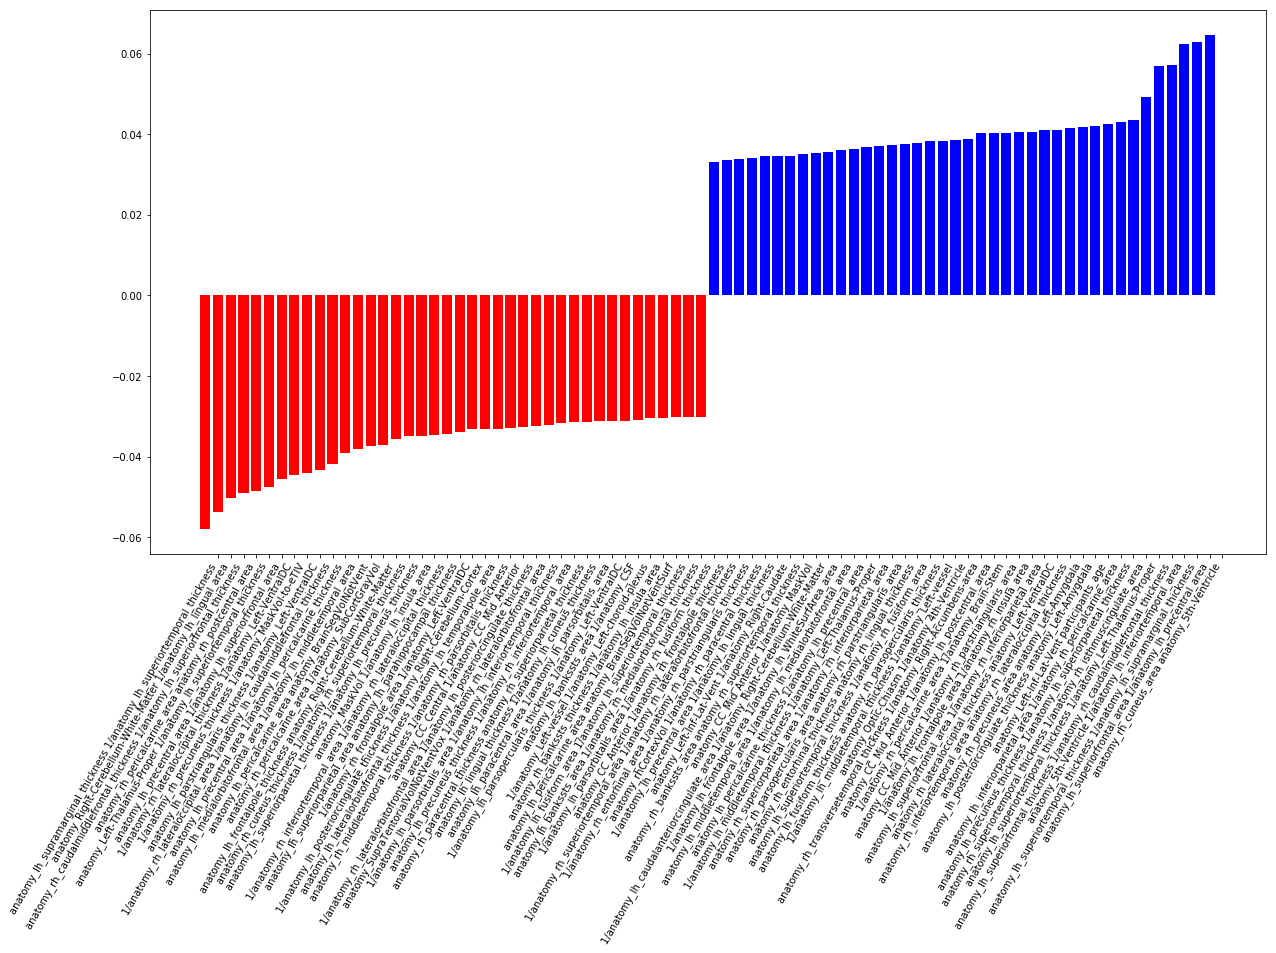

In [356]:
visualize_coefficients(log_reg1, feature_names=mi_selected_columns, n_top_features=40)

In [357]:
# coef = log_reg.coef_.ravel()
# poly_cols = poly_feature.get_feature_names(input_features=cols)
# np.savez_compressed("log_reg_coef_f_f2_1f_anatomy_participant_test_size=05.npz", coef=coef, poly_cols=poly_cols)

In [358]:
# log_reg_coef_2xfeatures = np.load("log_reg_coef_2xfeatures.npz")
# coef = log_reg_coef_2xfeatures['coef']
# poly_cols = log_reg_coef_2xfeatures['poly_cols']

In [359]:
coef1 = log_reg1.coef_.ravel()
positive_coefficients_1 = np.argsort(coef1)
negative_coefficients_1 = np.argsort(coef1)

In [360]:
coef1.min(), coef1.max(), np.abs(coef1).min()

(-0.057989707093967356, 0.0647044190404161, 1.67276576169317e-05)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


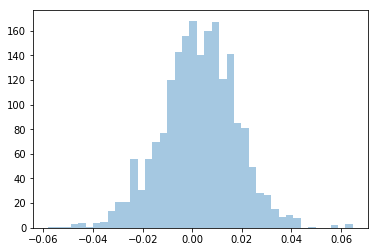

In [361]:
sns.distplot(coef1, kde=False)

In [363]:
n_top_features = 90

positive_coefficients = positive_coefficients_1[-n_top_features:]
negative_coefficients = negative_coefficients_1[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_mi_selected_columns = np.array(mi_selected_columns)[interesting_coefficients].tolist()

In [364]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [365]:
results = evaluation(data2[top_mi_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.890 +- 0.008
Validation score ROC-AUC: 0.724 +- 0.015 

Training score accuracy: 0.811 +- 0.013
Validation score accuracy: 0.671 +- 0.015


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


90
```
Training score ROC-AUC: 0.894 +- 0.013
Validation score ROC-AUC: 0.730 +- 0.015 

Training score accuracy: 0.809 +- 0.019
Validation score accuracy: 0.673 +- 0.018
```

### Feature importance of Corr selected features

In [212]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data2[corr_selected_columns], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [213]:
log_reg2 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

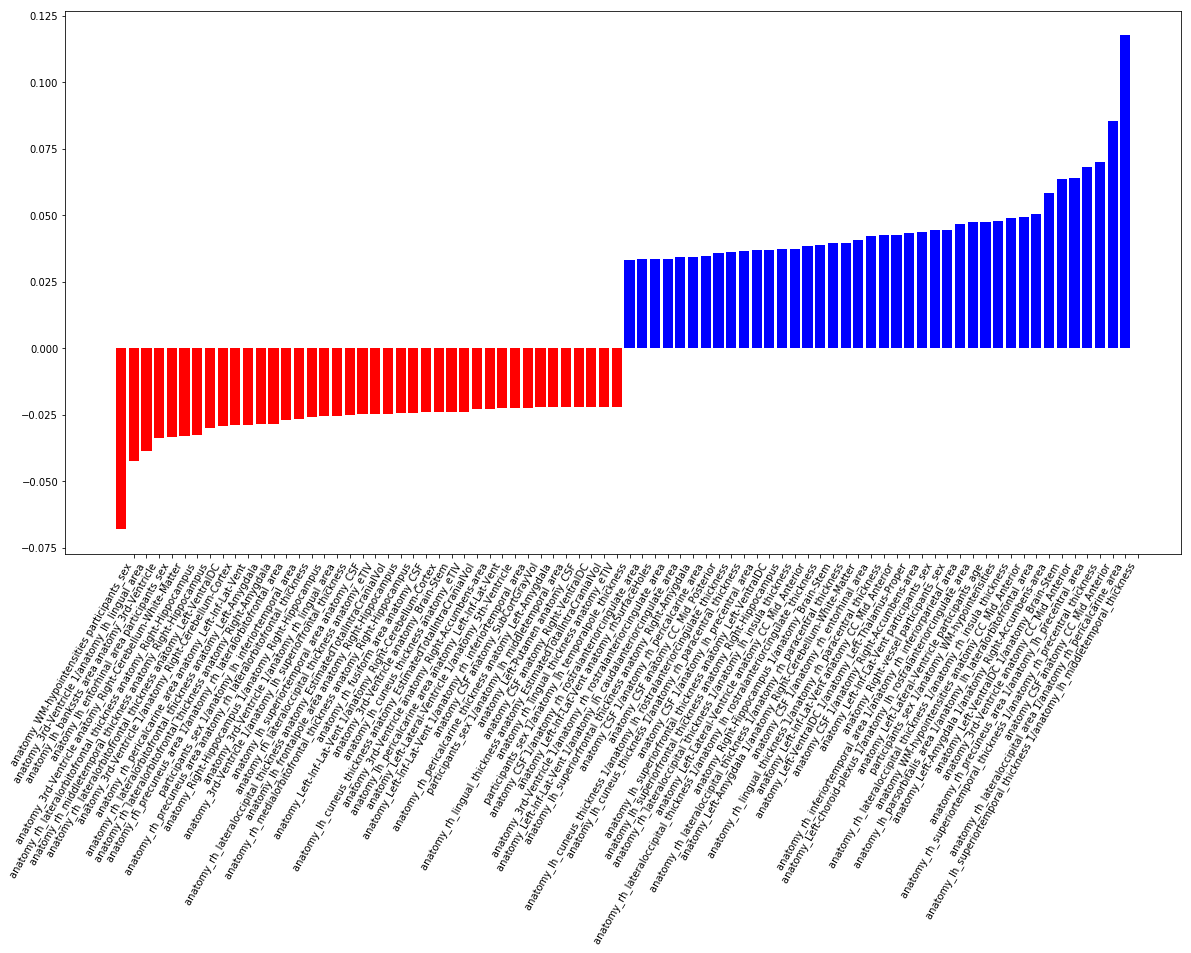

In [214]:
visualize_coefficients(log_reg2, feature_names=corr_selected_columns, n_top_features=40)

In [215]:
coef2 = log_reg2.coef_.ravel()
positive_coefficients_2 = np.argsort(coef2)
negative_coefficients_2 = np.argsort(coef2)

In [216]:
coef2.min(), coef2.max(), np.abs(coef2).min()

(-0.06806642864296801, 0.11774109744967291, 4.6007422852028507e-07)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


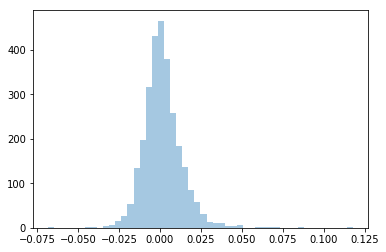

In [218]:
sns.distplot(coef2, kde=False)

In [280]:
n_top_features = 110

positive_coefficients = positive_coefficients_2[-n_top_features:]
negative_coefficients = negative_coefficients_2[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_corr_selected_columns = np.array(corr_selected_columns)[interesting_coefficients].tolist()

In [235]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [236]:
results = evaluation(data2[top_corr_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.859 +- 0.024
Validation score ROC-AUC: 0.736 +- 0.010 

Training score accuracy: 0.774 +- 0.024
Validation score accuracy: 0.671 +- 0.011


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.6s finished


120
```
Training score ROC-AUC: 0.869 +- 0.015
Validation score ROC-AUC: 0.736 +- 0.012 

Training score accuracy: 0.787 +- 0.020
Validation score accuracy: 0.673 +- 0.010
```

### Feature importance of PCA features

In [238]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(pca_data_df[pca_cols], data2['target'])

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [240]:
log_reg3 = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

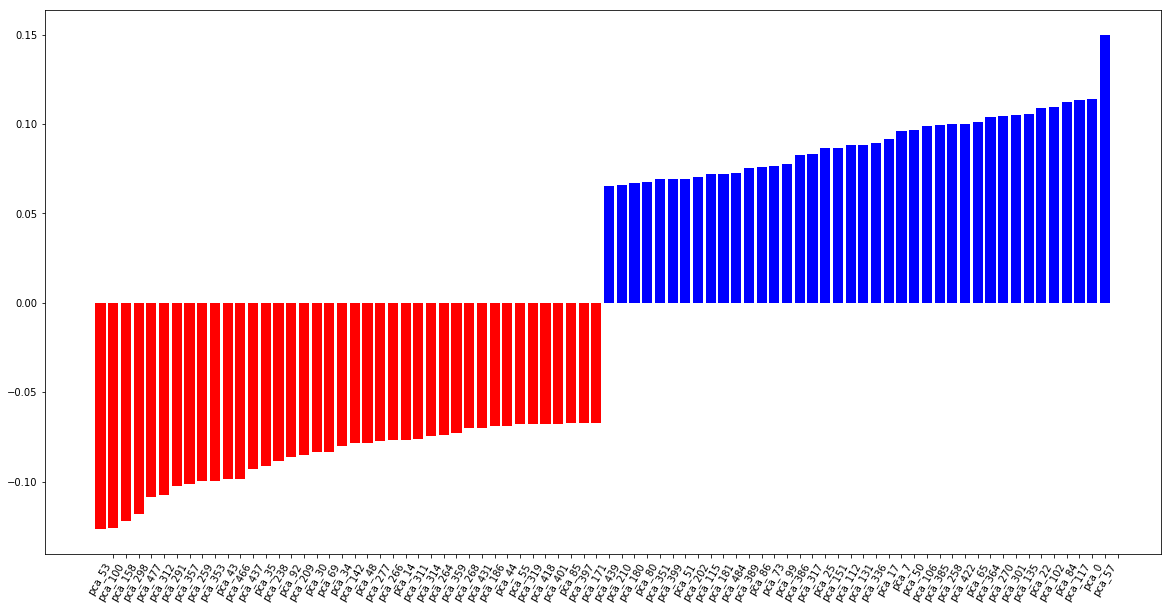

In [241]:
visualize_coefficients(log_reg3, feature_names=pca_cols, n_top_features=40)

In [243]:
coef3 = log_reg3.coef_.ravel()
positive_coefficients_3 = np.argsort(coef3)
negative_coefficients_3 = np.argsort(coef3)

In [244]:
coef3.min(), coef3.max(), np.abs(coef3).min()

(-0.12671464934363416, 0.14980653510843137, 2.9188812699494157e-05)

/opt/conda/envs/rampwf/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


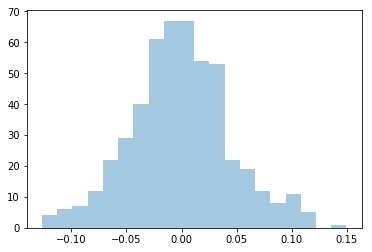

In [245]:
sns.distplot(coef3, kde=False)

In [274]:
n_top_features = 85

positive_coefficients = positive_coefficients_3[-n_top_features:]
negative_coefficients = negative_coefficients_3[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

top_pca_selected_columns = np.array(pca_cols)[interesting_coefficients].tolist()

In [275]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

In [276]:
results = evaluation(pca_data_df[top_pca_selected_columns], data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.971 +- 0.008
Validation score ROC-AUC: 0.817 +- 0.021 

Training score accuracy: 0.904 +- 0.015
Validation score accuracy: 0.739 +- 0.018


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.1s finished


95
```
Training score ROC-AUC: 0.971 +- 0.008
Validation score ROC-AUC: 0.817 +- 0.021 

Training score accuracy: 0.904 +- 0.015
Validation score accuracy: 0.739 +- 0.018
```

Mix of best

In [316]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 90
        

class FeatureExtractor(BaseEstimator, TransformerMixin):
        
    def fit(self, X_df, y):
        return self

    def transform(self, X):
        # get only the anatomical information
#         l1 = len(top_pca_selected_columns)
#         l2 = len(top_mi_selected_columns) 
#         return X[:, :l1], X[:, l1:l2], X[:, l2:]
        l1 = len(top_pca_selected_columns)
        return X[:, :l1], X[:, l1:]    
    
    
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe1_cv = make_pipeline(StandardScaler(), 
                                 LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe1_cv.fit(X[0], y)
        best_C1 = pipe1_cv.named_steps['logisticregressioncv'].C_[0]
        
        pipe2_cv = make_pipeline(StandardScaler(), 
                                 LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe2_cv.fit(X[1], y)
        best_C2 = pipe2_cv.named_steps['logisticregressioncv'].C_[0]

#         pipe3_cv = make_pipeline(StandardScaler(), 
#                                  LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
#         pipe3_cv.fit(X[2], y)
#         best_C3 = pipe3_cv.named_steps['logisticregressioncv'].C_[0]
        
        
        self.clf1 = make_pipeline(StandardScaler(), LogisticRegression(C=best_C1, random_state=seed))
        self.clf1.fit(X[0], y)

        self.clf2 = make_pipeline(StandardScaler(), LogisticRegression(C=best_C2, random_state=seed))
        self.clf2.fit(X[1], y)

#         self.clf3 = make_pipeline(StandardScaler(), LogisticRegression(C=best_C3, random_state=seed))
#         self.clf3.fit(X[2], y)
                
        return self
        
    def predict(self, X):        
        probas = self.predict_proba(X)[:, 1]
        preds = (probas > 0.5).astype(np.int)         
        return preds

    def predict_proba(self, X):
        p1 = self.clf1.predict_proba(X[0])
        p2 = self.clf2.predict_proba(X[1])
#         p3 = self.clf3.predict_proba(X[2])
        return 0.7 * p1 + 0.30 * p2 # + 0.0 * p3

In [317]:
X = np.concatenate(
    [
        pca_data_df[top_pca_selected_columns].values,
        data2[top_corr_selected_columns].values,
#         data2[top_mi_selected_columns].values
    ],
    axis=1
)

results = evaluation(X, data2['target'])

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.971 +- 0.010
Validation score ROC-AUC: 0.829 +- 0.019 

Training score accuracy: 0.904 +- 0.014
Validation score accuracy: 0.753 +- 0.015


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.7s finished


70 - 30 - 0
```
Training score ROC-AUC: 0.971 +- 0.010
Validation score ROC-AUC: 0.829 +- 0.019 

Training score accuracy: 0.904 +- 0.014
Validation score accuracy: 0.753 +- 0.015
```

In [ ]:
top_corr_selected_columns

### Basic logistic regression on poly features

In [50]:
X_df = data_train
for fname in topk_2xfeature_names:
    if " " in fname:
        X_df.loc[:, fname] = 0.0
        f1, f2 = fname.split(" ")
        X_df.loc[:, fname] = X_df[f1] * X_df[f2]

In [51]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        # create polynomial features:
#         if X_df['participants_sex'].unique().dtype != int:
#             X_df['participants_sex'] = X_df['participants_sex'].map({'F': 0, 'M': 1}) 
#         for fname in topk_2xfeature_names:
#             if " " in fname:
#                 X_df.loc[:, fname] = 0.0
#                 f1, f2 = fname.split(" ")
#                 X_df.loc[:, fname] = X_df[f1] * X_df[f2]
        return X_df[topk_2xfeature_names + topk_feature_names]
    
    
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
seed = 100
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [52]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.760 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.694 +- 0.016


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.1s finished


Find optimal number of features

In [104]:
n_top_features = 1000
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()


X_df = data_train
for fname in topk_2xfeature_names:
    if " " in fname:
        X_df.loc[:, fname] = 0.0
        f1, f2 = fname.split(" ")
        X_df.loc[:, fname] = X_df[f1] * X_df[f2]

In [102]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [113]:
positive_coefficients = np.argsort(coef)
negative_coefficients = np.argsort(coef)


class _FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self, features):
        self.features = features
    
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        return X_df[self.features]

    
def _evaluation(X, y, features):
    pipe = make_pipeline(_FeatureExtractor(features), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


def score(params):
    num_features = params['num_features']
    
    print("Trial: num_features: {}".format(num_features), end=" -> ")
    
    n_top_features = num_features
    positive_coefficients_ = positive_coefficients[-n_top_features:]
    negative_coefficients_ = negative_coefficients[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients_, positive_coefficients_])
    topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()
        
    results = _evaluation(data_train, labels_train, topk_2xfeature_names + topk_feature_names)
    roc = np.mean(results['test_roc_auc']) 
    acc = np.mean(results['test_accuracy'])
    res = roc + acc
    print("Score: roc = {} | acc = {}".format(roc, acc))
    return {'loss': 2.0 - res, 'status': STATUS_OK}
    
    
def get_num_features():
    return hp.randint('num_features', 750) + 150
    
    
def optimize(trials, max_evals):
    params = {'num_features': get_num_features()}
    best = fmin(score, params, algo=tpe.suggest, trials=trials, max_evals=max_evals)    
    return best


trials = Trials()
best_num_features = optimize(trials, max_evals=50)
best_num_features

Trial: num_features: 644 -> Score: roc = 0.7835549114737572 | acc = 0.7120567375886525
Trial: num_features: 186 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


Score: roc = 0.7466561653329973 | acc = 0.6828014184397164
Trial: num_features: 605 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.8s finished


Score: roc = 0.783729443639342 | acc = 0.7148936170212765
Trial: num_features: 350 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7749593598386995 | acc = 0.7070921985815602
Trial: num_features: 408 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.7s finished


Score: roc = 0.7816583706130679 | acc = 0.7122340425531914
Trial: num_features: 629 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


Score: roc = 0.7852416356877324 | acc = 0.7152482269503546
Trial: num_features: 395 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Score: roc = 0.7802665238485287 | acc = 0.7101063829787234
Trial: num_features: 711 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.3s finished


Score: roc = 0.7889150022052801 | acc = 0.7145390070921986
Trial: num_features: 547 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7863039506017264 | acc = 0.7157801418439717
Trial: num_features: 773 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Score: roc = 0.7863726293239243 | acc = 0.7145390070921985
Trial: num_features: 769 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7836330413962573 | acc = 0.7115248226950355
Trial: num_features: 232 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.6s finished


Score: roc = 0.756112406275597 | acc = 0.6920212765957447
Trial: num_features: 875 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


Score: roc = 0.7857601915443262 | acc = 0.7143617021276596
Trial: num_features: 606 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.3s finished


Score: roc = 0.7834131434692206 | acc = 0.7148936170212767
Trial: num_features: 425 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Score: roc = 0.7814063386050029 | acc = 0.7088652482269503
Trial: num_features: 452 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7843992187007749 | acc = 0.7111702127659574
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.0s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 846 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7872345787915066 | acc = 0.7161347517730496
Trial: num_features: 520 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.9s finished


Score: roc = 0.7847848276731144 | acc = 0.7152482269503546
Trial: num_features: 228 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Score: roc = 0.7537981223615399 | acc = 0.6906028368794326
Trial: num_features: 156 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.4s finished


Score: roc = 0.7433148509860753 | acc = 0.677836879432624
Trial: num_features: 518 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.0s finished


Score: roc = 0.7827988154495621 | acc = 0.7118794326241135
Trial: num_features: 807 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.6s finished


Score: roc = 0.7866523848528764 | acc = 0.7131205673758865
Trial: num_features: 437 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Score: roc = 0.7837149517988784 | acc = 0.7118794326241135
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 585 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7851490139247685 | acc = 0.7115248226950355
Trial: num_features: 550 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.1s finished


Score: roc = 0.7841963329342827 | acc = 0.7127659574468085
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 310 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.7663656984437023 | acc = 0.6957446808510637
Trial: num_features: 166 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.5s finished


Score: roc = 0.7435486106735555 | acc = 0.6764184397163121
Trial: num_features: 284 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished


Score: roc = 0.7614932896477853 | acc = 0.6904255319148935
Trial: num_features: 276 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.1s finished


Score: roc = 0.7601335769642745 | acc = 0.6890070921985816
Trial: num_features: 612 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.5s finished


Score: roc = 0.7843254993384161 | acc = 0.7177304964539009
Trial: num_features: 341 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.1s finished


Score: roc = 0.7740690567702098 | acc = 0.7053191489361701
Trial: num_features: 488 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


Score: roc = 0.7838806628441812 | acc = 0.7086879432624114
Trial: num_features: 169 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.1s finished


Score: roc = 0.7455050091361604 | acc = 0.6810283687943264
Trial: num_features: 762 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.3s finished


Score: roc = 0.7849310062377922 | acc = 0.7120567375886525
Trial: num_features: 619 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.7s finished


Score: roc = 0.7841578980530527 | acc = 0.7157801418439715
Trial: num_features: 255 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Score: roc = 0.7568615714195703 | acc = 0.6895390070921985
Trial: num_features: 562 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.0s finished


Score: roc = 0.7833129607460148 | acc = 0.7140070921985815
Trial: num_features: 254 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished


Score: roc = 0.7578741100119715 | acc = 0.6907801418439716
Trial: num_features: 743 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7872465503118896 | acc = 0.7129432624113475
Trial: num_features: 833 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7880788860185244 | acc = 0.7148936170212765
Trial: num_features: 515 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.2s finished


Score: roc = 0.7839984878079516 | acc = 0.7134751773049646
Trial: num_features: 181 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.0s finished


Score: roc = 0.7469371810219898 | acc = 0.6833333333333333
Trial: num_features: 688 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.4s finished


Score: roc = 0.7851773675256758 | acc = 0.7122340425531914
Trial: num_features: 806 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7854640539348497 | acc = 0.7122340425531914
Trial: num_features: 836 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.4s finished


Score: roc = 0.788337218826791 | acc = 0.7152482269503546
Trial: num_features: 831 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Score: roc = 0.7863820805242265 | acc = 0.7129432624113475
Trial: num_features: 194 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Score: roc = 0.7443670846197467 | acc = 0.6799645390070922
Trial: num_features: 332 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.5s finished


Score: roc = 0.7705380883372188 | acc = 0.700354609929078
Trial: num_features: 266 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.1s finished


Score: roc = 0.7579194757734232 | acc = 0.6879432624113474
Trial: num_features: 285 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.2s finished


Score: roc = 0.7622348938315165 | acc = 0.6907801418439716
Trial: num_features: 614 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.6s finished


Score: roc = 0.7825215802406906 | acc = 0.7154255319148938
Trial: num_features: 552 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


Score: roc = 0.7835870455547854 | acc = 0.7161347517730496
Trial: num_features: 380 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7773895784764665 | acc = 0.7074468085106382
Trial: num_features: 357 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Score: roc = 0.776736815575578 | acc = 0.7079787234042553
Trial: num_features: 324 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.0s finished


Score: roc = 0.7660695608342261 | acc = 0.6943262411347517
Trial: num_features: 618 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.8s finished


Score: roc = 0.7836702161174469 | acc = 0.7143617021276596
Trial: num_features: 473 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.7s finished


Score: roc = 0.7835271879528699 | acc = 0.7085106382978723
Trial: num_features: 892 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.0s finished


Score: roc = 0.7858276101064835 | acc = 0.7148936170212766
Trial: num_features: 653 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.9s finished


Score: roc = 0.7832373511435952 | acc = 0.7127659574468086
Trial: num_features: 236 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.4s finished


Score: roc = 0.7587335391594733 | acc = 0.6891843971631205
Trial: num_features: 379 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.9s finished


Score: roc = 0.7787203074790499 | acc = 0.7069148936170213
Trial: num_features: 202 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.8s finished


Score: roc = 0.746930250141768 | acc = 0.6849290780141845
Trial: num_features: 531 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7858042971457374 | acc = 0.7166666666666667
Trial: num_features: 519 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.4s finished


Score: roc = 0.78453531598513 | acc = 0.7129432624113475
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.5s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 208 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.5s finished


Score: roc = 0.7457375086636002 | acc = 0.6822695035460994
Trial: num_features: 459 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7801631907252221 | acc = 0.7058510638297872
Trial: num_features: 334 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Score: roc = 0.7728863965723647 | acc = 0.701063829787234
Trial: num_features: 702 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.8s finished


Score: roc = 0.787430533677777 | acc = 0.7099290780141843
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.9s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 720 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7868388885388444 | acc = 0.7134751773049646
Trial: num_features: 237 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.757903093692899 | acc = 0.6895390070921985
Trial: num_features: 590 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished


Score: roc = 0.785972528511121 | acc = 0.7131205673758865
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 649 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.2s finished


Score: roc = 0.7849184046373889 | acc = 0.7159574468085107
Trial: num_features: 314 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.9s finished


Score: roc = 0.7655062692962006 | acc = 0.6946808510638297
Trial: num_features: 462 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7841786906937182 | acc = 0.7085106382978723
Trial: num_features: 187 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7465314094890051 | acc = 0.6836879432624114
Trial: num_features: 751 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


Score: roc = 0.7886314661962068 | acc = 0.7148936170212766
Trial: num_features: 463 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.7827383277676265 | acc = 0.7076241134751773
Trial: num_features: 512 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.7s finished


Score: roc = 0.7848598071955137 | acc = 0.7111702127659574
Trial: num_features: 779 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.9s finished


Score: roc = 0.7853386680108373 | acc = 0.7120567375886526
Trial: num_features: 626 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7845201940646462 | acc = 0.7127659574468086
Trial: num_features: 602 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.6s finished


Score: roc = 0.7865981979711424 | acc = 0.7170212765957447
Trial: num_features: 791 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.4s finished


Score: roc = 0.7879478293743305 | acc = 0.7148936170212765
Trial: num_features: 450 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7851565748850104 | acc = 0.7093971631205673
Trial: num_features: 436 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7824547917585533 | acc = 0.7081560283687943
Trial: num_features: 886 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7862346417995085 | acc = 0.7148936170212765
Trial: num_features: 203 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished


Score: roc = 0.7449404574380947 | acc = 0.6826241134751774
Trial: num_features: 877 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7847022871904732 | acc = 0.7138297872340427
Trial: num_features: 885 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.3s finished


Score: roc = 0.785566126898116 | acc = 0.7163120567375887
Trial: num_features: 542 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.0s finished


Score: roc = 0.784821372314284 | acc = 0.7143617021276596
Trial: num_features: 339 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.7735983869951484 | acc = 0.7037234042553191
Trial: num_features: 712 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.2s finished


Score: roc = 0.7882288450633231 | acc = 0.7147163120567376
Trial: num_features: 692 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.0s finished


Score: roc = 0.7851408228845063 | acc = 0.7113475177304964
Trial: num_features: 598 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.3s finished


Score: roc = 0.7869913679037237 | acc = 0.7140070921985815
Trial: num_features: 220 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.8s finished


Score: roc = 0.7537464557998866 | acc = 0.6893617021276596
Trial: num_features: 329 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.8s finished


Score: roc = 0.7711108310755466 | acc = 0.699822695035461
Trial: num_features: 464 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.1s finished


Score: roc = 0.7823533488753072 | acc = 0.7069148936170213
Trial: num_features: 584 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.3s finished


Score: roc = 0.7840407031693024 | acc = 0.7092198581560283
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.0s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 747 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.787430533677777 | acc = 0.7152482269503546
Trial: num_features: 631 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.8s finished


Score: roc = 0.7849820427194254 | acc = 0.7170212765957447
Trial: num_features: 219 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.3s finished


Score: roc = 0.7536721063575074 | acc = 0.6900709219858155
Trial: num_features: 509 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Score: roc = 0.7845573687858358 | acc = 0.7122340425531914
Trial: num_features: 407 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.8s finished


Score: roc = 0.7816508096528259 | acc = 0.7093971631205673
Trial: num_features: 274 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7618335328586731 | acc = 0.6920212765957446
Trial: num_features: 355 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7757891752252537 | acc = 0.7083333333333334
Trial: num_features: 532 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.9s finished


Score: roc = 0.7839310692457943 | acc = 0.7145390070921985
Trial: num_features: 788 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.2s finished


Score: roc = 0.7870770587864659 | acc = 0.7156028368794326
Trial: num_features: 182 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.0s finished


Score: roc = 0.747387058156386 | acc = 0.6835106382978724
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 850 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Score: roc = 0.787089030306849 | acc = 0.7140070921985816
Trial: num_features: 715 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.8s finished


Score: roc = 0.7852554974481759 | acc = 0.7108156028368795
Trial: num_features: 857 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7856625291412009 | acc = 0.7131205673758865
Trial: num_features: 812 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.7s finished


Score: roc = 0.7885671980341504 | acc = 0.7152482269503546
Trial: num_features: 205 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.8s finished


Score: roc = 0.7443362106987588 | acc = 0.6847517730496454
Trial: num_features: 215 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7495854073467331 | acc = 0.6820921985815602
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.7s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 198 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7468388885388444 | acc = 0.6819148936170214
Trial: num_features: 322 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.0s finished


Score: roc = 0.7677191103270115 | acc = 0.6969858156028368
Trial: num_features: 789 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


Score: roc = 0.7867059416545902 | acc = 0.7136524822695035
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.3s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 817 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.0s finished


Score: roc = 0.789012034528385 | acc = 0.7166666666666667
Trial: num_features: 811 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Score: roc = 0.7886932140381828 | acc = 0.7157801418439715
Trial: num_features: 646 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.7s finished


Score: roc = 0.7852542372881356 | acc = 0.7141843971631205
Trial: num_features: 822 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Score: roc = 0.7893610988595553 | acc = 0.7173758865248226
Trial: num_features: 693 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.2s finished


Score: roc = 0.7855598260979144 | acc = 0.7115248226950354
Trial: num_features: 778 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.2s finished


Score: roc = 0.7868262869384411 | acc = 0.7140070921985816
Trial: num_features: 430 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


Score: roc = 0.7810087581122803 | acc = 0.7062056737588652
Trial: num_features: 554 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.4s finished


Score: roc = 0.7826463360846827 | acc = 0.7125886524822694
Trial: num_features: 630 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.1s finished


Score: roc = 0.7848932014365825 | acc = 0.7150709219858157
Trial: num_features: 157 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.9s finished


Score: roc = 0.7431989162623653 | acc = 0.6787234042553192
Trial: num_features: 841 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.7s finished


Score: roc = 0.7876088463234832 | acc = 0.7159574468085107
Trial: num_features: 438 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.9s finished


Score: roc = 0.7824560519185937 | acc = 0.7115248226950355
Trial: num_features: 569 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.7s finished


Score: roc = 0.7849511687984373 | acc = 0.7141843971631204
Trial: num_features: 837 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   17.3s finished


Score: roc = 0.787786528889169 | acc = 0.7156028368794326
Trial: num_features: 469 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.3s finished


Score: roc = 0.7816596307731082 | acc = 0.7058510638297872
Trial: num_features: 855 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.9s finished


Score: roc = 0.78542624913364 | acc = 0.7138297872340426
Trial: num_features: 707 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.7s finished


Score: roc = 0.7872667128725348 | acc = 0.7113475177304964
Trial: num_features: 824 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.6s finished


Score: roc = 0.7861508411568269 | acc = 0.7156028368794327
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.1s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 587 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   21.6s finished


Score: roc = 0.7828826160922436 | acc = 0.7092198581560283
Trial: num_features: 523 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.7s finished


Score: roc = 0.7844288324617226 | acc = 0.7124113475177305
Trial: num_features: 758 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   16.8s finished


Score: roc = 0.7885249826727995 | acc = 0.7168439716312057
Trial: num_features: 822 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   22.0s finished


Score: roc = 0.7893610988595553 | acc = 0.7173758865248226
Trial: num_features: 262 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   23.6s finished


Score: roc = 0.7574210824774746 | acc = 0.6911347517730496
Trial: num_features: 832 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.7s finished


Score: roc = 0.7878892319324555 | acc = 0.7145390070921986
Trial: num_features: 361 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.0s finished


Score: roc = 0.7768495998991872 | acc = 0.7090425531914893
Trial: num_features: 575 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.4s finished


Score: roc = 0.7856795413017454 | acc = 0.7150709219858156
Trial: num_features: 400 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   18.7s finished


Score: roc = 0.7799426627181651 | acc = 0.7113475177304964
Trial: num_features: 257 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   14.5s finished


Score: roc = 0.7585917711549367 | acc = 0.6895390070921985
Trial: num_features: 858 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.0s finished


Score: roc = 0.7861905361980972 | acc = 0.7129432624113475
Trial: num_features: 382 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   24.5s finished


Score: roc = 0.7787505513200177 | acc = 0.7069148936170213
Trial: num_features: 678 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   15.2s finished


Score: roc = 0.7838315166026085 | acc = 0.7117021276595745
Trial: num_features: 229 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   20.7s finished


Score: roc = 0.7536481633167413 | acc = 0.6902482269503546
Trial: num_features: 887 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.9s finished


Score: roc = 0.7859429147501733 | acc = 0.7173758865248228
Trial: num_features: 216 -> 

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.3s finished
Process ForkPoolWorker-13913:
Process ForkPoolWorker-13914:
Traceback (most recent call last):
Process ForkPoolWorker-13912:
Traceback (most recent call last):
  File "/opt/conda/envs/rampwf/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [119]:
best_num_features = 822

n_top_features = best_num_features
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
topk_2xfeature_names = np.array(poly_cols)[interesting_coefficients].tolist()
print(len(topk_2xfeature_names))

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):                
        return self

    def transform(self, X_df):
        return X_df[topk_2xfeature_names + topk_feature_names]


results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

1644
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.789 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.717 +- 0.017


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   26.0s finished


## Test size = 0.5

### Anatomy + Participant

715
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.711 +- 0.018
```


700
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.788 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.711 +- 0.015
```

650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.710 +- 0.017
```


625
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.784 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.714 +- 0.017
```


600
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.787 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.718 +- 0.017
```


575
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.786 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.715 +- 0.015
```


550
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.784 +- 0.012 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.713 +- 0.010
```

500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.013 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.712 +- 0.017
```

450
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.785 +- 0.015 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.709 +- 0.020
```


250
```
Training score ROC-AUC: 0.998 +- 0.005
Validation score ROC-AUC: 0.756 +- 0.014 

Training score accuracy: 0.994 +- 0.019
Validation score accuracy: 0.691 +- 0.019
```



120
```
Training score ROC-AUC: 0.989 +- 0.020
Validation score ROC-AUC: 0.739 +- 0.019 

Training score accuracy: 0.969 +- 0.046
Validation score accuracy: 0.677 +- 0.017
```

## Test size = 0.2

#### Anatomy + Participant

715
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.899 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.812 +- 0.021
```


700
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.899 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.021
```

695
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.896 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.811 +- 0.022
```


675
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.895 +- 0.018 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.020
```


650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.892 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.821 +- 0.020
```


625
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.891 +- 0.016 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.820 +- 0.021
```


500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.884 +- 0.017 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.819 +- 0.020
```


150
```
Training score ROC-AUC: 0.982 +- 0.015
Validation score ROC-AUC: 0.797 +- 0.014 

Training score accuracy: 0.935 +- 0.032
Validation score accuracy: 0.712 +- 0.022
```


#### Anatomy only

650
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.892 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.822 +- 0.022
```


600
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.889 +- 0.024 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.810 +- 0.029
```


500
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.886 +- 0.020 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.802 +- 0.020
```


400
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.876 +- 0.020 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.799 +- 0.024
```


300
```
Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.853 +- 0.022 

Training score accuracy: 1.000 +- 0.000
Validation score accuracy: 0.769 +- 0.023
```


100
```
Training score ROC-AUC: 0.945 +- 0.014
Validation score ROC-AUC: 0.754 +- 0.019 

Training score accuracy: 0.873 +- 0.016
Validation score accuracy: 0.685 +- 0.023
```


baseline 1x features:
```
Training score ROC-AUC: 0.819 +- 0.004
Validation score ROC-AUC: 0.741 +- 0.018 

Training score accuracy: 0.744 +- 0.008
Validation score accuracy: 0.676 +- 0.018
```

In [66]:
len(topk_feature_names), len(topk_2xfeature_names)

(82, 1300)

Check coeff importance:

In [67]:
pipe = make_pipeline(FeatureExtractor(), Classifier())

In [68]:
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [69]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

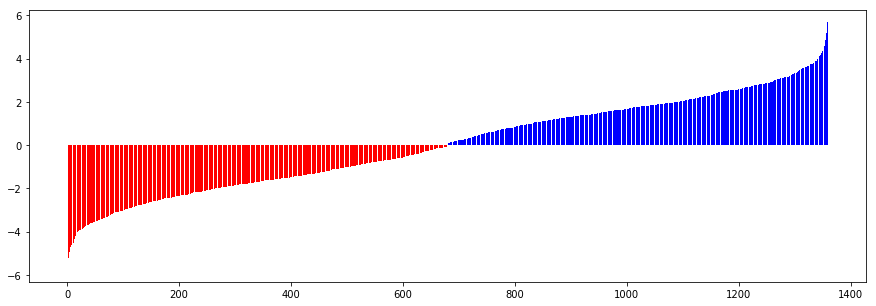

In [84]:
visualize_coefficients(log_reg, feature_names=None, n_top_features=680)

In [123]:
len(topk_2xfeature_names)

1644

In [347]:
print("[", end="")
for f in top_corr_selected_columns:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_WM-hypointensities participants_sex", "anatomy_3rd-Ventricle 1/anatomy_lh_lingual_area", "anatomy_lh_bankssts_area anatomy_3rd-Ventricle", "anatomy_lh_entorhinal_area participants_sex", "anatomy_3rd-Ventricle anatomy_Right-Cerebellum-White-Matter", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Right-Hippocampus", "anatomy_rh_middletemporal_thickness anatomy_Right-Hippocampus", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-VentralDC", "anatomy_3rd-Ventricle 1/anatomy_Right-Cerebellum-Cortex", "anatomy_rh_pericalcarine_area anatomy_Left-Inf-Lat-Vent", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Left-Amygdala", "anatomy_rh_lateralorbitofrontal_thickness anatomy_Right-Amygdala", "anatomy_rh_precuneus_area 1/anatomy_rh_lateralorbitofrontal_area", "participants_sex 1/anatomy_lh_inferiortemporal_area", "anatomy_rh_precuneus_area anatomy_rh_lateralorbitofrontal_thickness", "anatomy_Right-Hippocampus 1/anatomy_Right-Hippocampus", "anatomy_3rd-Ventricle 1/anatomy_